# Model Selection

##### *In which we choose the best model to predict the age of a crab.*

###### [GitHub Repository](https://github.com/ahester57/ai_workshop/tree/master/notebooks/time_for_crab/1-models)

###### [Notebook Viewer](https://nbviewer.jupyter.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/1-models/models.ipynb)

###### [Kaggle Dataset](https://www.kaggle.com/sidhus/crab-age-prediction)


### Define Constants


In [130]:
%%time
CACHE_FILE = '../cache/crabs.feather'
NEXT_CACHE_FILE = '../cache/splitcrabs.feather'
NEXT_NOTEBOOK = '../2-features/features.ipynb'
MODEL_CHECKPOINT_FILE = '../cache/best_model.weights.h5'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex_F','Sex_M','Sex_I','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]

NUM_EPOCHS = 100
VALIDATION_SPLIT = 0.2



CPU times: total: 0 ns
Wall time: 0 ns


### Import Libraries


In [131]:
%%time
from notebooks.time_for_crab.mlutils import display_df, generate_neural_pyramid
from notebooks.time_for_crab.mlutils import plot_training_loss, plot_training_loss_from_dict, plot_true_vs_pred_from_dict
from notebooks.time_for_crab.mlutils import score_combine, score_comparator, score_model

import keras

keras_backend = keras.backend.backend()
print(f'Keras version: {keras.__version__}')
print(f'Keras backend: {keras_backend}')
if keras_backend == 'tensorflow':
    import tensorflow as tf
    print(f'TensorFlow version: {tf.__version__}')
    print(f'TensorFlow devices: {tf.config.list_physical_devices()}')
elif keras_backend == 'torch':
    import torch
    print(f'Torch version: {torch.__version__}')
    print(f'Torch devices: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    # torch supports windows-native cuda, but CPU was faster for this task
elif keras_backend == 'jax':
    import jax
    print(f'JAX version: {jax.__version__}')
    print(f'JAX devices: {jax.devices()}')
else:
    print('Unknown backend; Proceed with caution.')

import numpy as np
import pandas as pd

from typing import Generator

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


Keras version: 3.3.3
Keras backend: tensorflow
TensorFlow version: 2.16.1
TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU times: total: 0 ns
Wall time: 998 µs


### Load Data from Cache

In the [previous section](../0-eda/overfit.ipynb), we saved the cleaned data to a cache file. Let's load it back.


In [132]:
%%time
crabs = pd.read_feather(CACHE_FILE)
display_df(crabs, show_distinct=True)


DataFrame shape: (3790, 11)
First 5 rows:
     Length  Diameter    Height     Weight  Shucked Weight  Viscera Weight  \
0  1.437500  1.174805  0.412598  24.640625       12.335938        5.585938   
1  0.887695  0.649902  0.212524   5.402344        2.296875        1.375000   
2  1.037109  0.774902  0.250000   7.953125        3.232422        1.601562   
3  1.174805  0.887695  0.250000  13.476562        4.750000        2.281250   
4  0.887695  0.662598  0.212524   6.902344        3.458984        1.488281   

   Shell Weight  Age  Sex_F  Sex_I  Sex_M  
0      6.746094    9   True  False  False  
1      1.559570    6  False  False   True  
2      2.763672    6  False   True  False  
3      5.246094   10   True  False  False  
4      1.701172    6  False   True  False  
<class 'pandas.core.frame.DataFrame'>
Index: 3790 entries, 0 to 3892
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          3790 non-nul

### Split the Data

Let's split the data into training and testing sets.

It is important to split the data before any data augmentation or normalization to avoid data leakage.  
Data leakage lets the model learn from the testing data, which can lead to overfitting.

In more general terms, *data leakage* is the phenomenon when the form of a label "leaks" into the training feature set.
An example this of occurred in 2021 for diagnosing Covid patients. Patients lying down on a bed were more likely to be "diagnosed" with Covid.
This is because patients confirmed to have Covid were more inclined to bed rest (Huyen, 2022). 

#### Importance of Data Shuffling

Shuffling the data is important to avoid any biases in the data.
The order of data shouldn't matter, so shuffling helps mitigate any biases.

Shuffling should occur before the test-train split to be most effective.

We don't have to worry about time-series data right now
(although we could reverse order by 'Age' and call it time-series by new feature 'Crab Birthdate'),
but shuffling can have a big impact on the model's performance.


In [133]:
%%time
# split features from target
X = crabs.drop([PREDICTION_TARGET], axis=1)
y = crabs[PREDICTION_TARGET]

# 80% training, 20% testing
train_size = int((1. - VALIDATION_SPLIT) * len(X))

# shuffle the data
random_indices = np.random.default_rng(42).permutation(np.arange(len(X)))

# split into train/test sets
X_train = X.iloc[random_indices[1:train_size]]
X_test = X.drop(X_train.index)
y_train = y.iloc[random_indices[1:train_size]]
# save the prediction target
y_test = y.drop(y_train.index)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')


X_train: (3031, 10)
X_test: (759, 10)
CPU times: total: 0 ns
Wall time: 1 ms


## Metrics Used

Throughout this notebook, we will use the following metrics to evaluate the regression model:

#### Mean Squared Error
 
- The best score is 0.0
- Lower is better.

#### Mean Absolute Error

- The best score is 0.0
- Lower is better.
- Less sensitive to outliers.

#### Explained Variance Score

- The best score is 1.0
- Lower is worse.

#### R2 Score

- The best score is 1.0
- Lower is worse.

#### Max Error

- The max error is the very worst score.
- Lower is better.
- Domain-specific.
- 10 years is a lot for a crab.


## Model Exploration

So far, we have not done any feature engineering, which can often be the most important part of the process.
Some new features could be constructed from our dataset which would call for a different model.
Nonetheless, we can start by using all features to set a baseline.
 
We will start with a few simple models to get a baseline accuracy.

We will use the following models:
- Naive Random Baseline
- Linear Regression
- Neural Networks
    - (64-32-16-8-1)
    - (32-16-8-1)
    - (16-8-1)
    - (8-1)
    - (4-1)
    - (2-1) 

### Naive Linear Regression

The simplest model is a naive linear regression model. It is untrained and will make random guesses.


In [134]:
%%time
# layer: input
layer_feature_input = keras.layers.Input(shape=(len(X_train.columns),))

# layer: normalizer
layer_feature_normalizer = keras.layers.Normalization(axis=-1)
layer_feature_normalizer.adapt(np.array(X_train))

# layer: output (linear regression)
layer_feature_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> linear
# initialize the all_models dictionary
all_models = {'linear': keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    layer_feature_output
])}

all_models['linear'].summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32 (132.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 15.6 ms
Wall time: 19.6 ms


#### Configure the Linear Model

*These will be used for all models unless otherwise specified.*

- **Optimizer**
    - Adam: Adaptive Moment Estimation [(Kingma & Ba, 2014)](https://arxiv.org/abs/1412.6980)
- **Loss Function**
    - Mean Squared Error (MSE)
        - This penalizes larger errors more than smaller errors.
        - We took out outliers in the data cleaning step, so this should perform better. 
- **Callbacks**
    - Model Checkpoint

##### Define Common Compile Options
##### Define Common Checkpoint Options


In [135]:
%%time
# some framework
def next_adam(learning_rate:float=0.001) -> Generator[keras.optimizers.Adam, None, None]:
    """Yield the next Adam optimizer with the given learning rate."""
    yield keras.optimizers.Adam(learning_rate=learning_rate)


def common_compile_options():
    optimizer = next(next_adam(learning_rate=0.001))
    loss = 'mean_squared_error'
    return {'optimizer': optimizer, 'loss': loss}


all_models['linear'].compile(**common_compile_options())

common_checkpoint_options = {
    'monitor': 'val_loss',
    'save_best_only': True,
    'save_weights_only': True,
    'mode': 'min'
}
linear_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_linear.keras'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 1e+03 µs


#### Score the Linear Model (Before Training)


In [136]:
%%time
untrained_linear_preds = all_models['linear'].predict(X_test).flatten()
# Utility functions imported from mlutils.py
untrained_linear_scores_df = score_model(untrained_linear_preds, np.array(y_test), index='untrained_linear')
# Add it to the leaderboard
leaderboard_df = score_combine(pd.DataFrame(), untrained_linear_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
CPU times: total: 15.6 ms
Wall time: 76.3 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124


#### Train the Linear Model

##### Define Common Fit Options


In [137]:
%%time
common_fit_options = {
    'x': X_train,
    'y': y_train,
    'epochs': NUM_EPOCHS,
    'verbose': 0,
    'validation_split': VALIDATION_SPLIT
}

linear_history = all_models['linear'].fit(
    **common_fit_options,
    callbacks=[linear_checkpoint]
)


CPU times: total: 2.05 s
Wall time: 7.64 s


#### Score the Linear Model


In [138]:
%%time
linear_preds = all_models['linear'].predict(X_test).flatten()
linear_scores_df = score_model(linear_preds, np.array(y_test), index='linear')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, linear_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
CPU times: total: 15.6 ms
Wall time: 54.3 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124
linear,13.761774,3.104374,-0.210572,-2.914958


### Neural Network Model

#### Neural Network Architecture

We will start with a deep (64-32-16-8-1) neural network with a few layers, gradually reducing the complexity from our overfit model.


- **Input Layer**
    - All of the features, please.
- **Normalizer Layer**
    - Adapted to all features in the training data. 
- **Hidden Layers**
    - Four dense layers each with 64 >> {layer_index} units and ReLU activation.
- **Output Layer**
    - Layer with one output.

> *I know what you're thinking*: "Why not start with a simpler model?"
> 
> *My answer to that*: This is for science, and we're going to test them all anyway. It's sometimes easier to copy and delete than it is to build from scratch. 


In [139]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 64, 32, 16, 8
num_hidden_layers = 4
num_units = 64
layer_deepest_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_deepest_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['64_32_16_8_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_deepest_hidden_relu_list,
    layer_deepest_output
])

all_models['64_32_16_8_1'].summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,478 (13.59 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 0 ns
Wall time: 22.6 ms


#### Configure the Neural Network Model

- **Optimizer**
    - Adam: Adaptive Moment Estimation [(Kingma & Ba, 2014)](https://arxiv.org/abs/1412.6980)
- **Loss Function**
    - Mean Squared Error (MSE)
        - This penalizes larger errors more than smaller errors.
        - We took out outliers in the data cleaning step, so this should perform better. 
- **Callbacks**
    - Model Checkpoint


In [140]:
%%time
all_models['64_32_16_8_1'].compile(**common_compile_options())

deepest_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_deep.keras'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 2.01 ms


#### Train the Neural Network Model

*We're not going to predict with the untrained model, as we already have a random baseline on the leaderboard.*


In [141]:
%%time
deepest_history = all_models['64_32_16_8_1'].fit(
    **common_fit_options,
    callbacks=[deepest_checkpoint]
)


CPU times: total: 3.08 s
Wall time: 8.98 s


#### Score the Neural Network Model


In [142]:
%%time
deepest_preds = all_models['64_32_16_8_1'].predict(X_test).flatten()
deepest_scores_df = score_model(deepest_preds, np.array(y_test), index='64_32_16_8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deepest_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CPU times: total: 46.9 ms
Wall time: 107 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124
linear,13.761774,3.104374,-0.210572,-2.914958
64_32_16_8_1,3.957087,1.439227,0.195975,0.189086


### Neural Network Model (32-16-8-1)

Let's cut the first layer out and see if it still has what it takes.


In [143]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 32, 16, 8
num_hidden_layers = 3
num_units = 32
layer_32_16_8_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_32_16_8_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['32_16_8_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_32_16_8_hidden_relu_list,
    layer_32_16_8_output
])

all_models['32_16_8_1'].summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,046 (4.09 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 0 ns
Wall time: 18.7 ms


#### Configure the (32-16-8-1) Neural Network Model


In [144]:
%%time
all_models['32_16_8_1'].compile(**common_compile_options())

deep_32_16_8_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_32_16_8.keras'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 998 µs


#### Train the (32-16-8-1) Neural Network Model

In [145]:
%%time
deep_32_16_8_history = all_models['32_16_8_1'].fit(
    **common_fit_options,
    callbacks=[deep_32_16_8_checkpoint]
)


CPU times: total: 2.75 s
Wall time: 8.49 s


#### Score the (32-16-8-1) Neural Network Model


In [146]:
%%time
deep_32_16_8_preds = all_models['32_16_8_1'].predict(X_test).flatten()
deep_32_16_8_scores_df = score_model(deep_32_16_8_preds, np.array(y_test), index='32_16_8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_32_16_8_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CPU times: total: 46.9 ms
Wall time: 105 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124
linear,13.761774,3.104374,-0.210572,-2.914958
64_32_16_8_1,3.957087,1.439227,0.195975,0.189086
32_16_8_1,3.846062,1.419220,0.211388,0.209502


### Neural Network Model (16-8-1)

The last one held up, so let's reduce it even more.


In [147]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 16, 8
num_hidden_layers = 2
num_units = 16
layer_16_8_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_16_8_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['16_8_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_16_8_hidden_relu_list,
    layer_16_8_output
])


CPU times: total: 0 ns
Wall time: 12 ms


#### Configure the (16-8-1) Neural Network Model


In [148]:
%%time
all_models['16_8_1'].compile(**common_compile_options())

deep_16_8_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_16_8.keras'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 2 ms


#### Train the (16-8-1) Neural Network Model


In [149]:
%%time
deep_16_8_history = all_models['16_8_1'].fit(
    **common_fit_options,
    callbacks=[deep_16_8_checkpoint]
)


CPU times: total: 3.36 s
Wall time: 8.17 s


#### Score the (16-8-1) Neural Network Model


In [150]:
%%time
deep_16_8_preds = all_models['16_8_1'].predict(X_test).flatten()
deep_16_8_scores_df = score_model(deep_16_8_preds, np.array(y_test), index='16_8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_16_8_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 78.1 ms
Wall time: 92.3 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124
linear,13.761774,3.104374,-0.210572,-2.914958
64_32_16_8_1,3.957087,1.439227,0.195975,0.189086
32_16_8_1,3.846062,1.419220,0.211388,0.209502
16_8_1,3.841158,1.434446,0.266957,0.266955


### Neural Network Model (8-1)

The last reduction didn't lose too much accuracy, so let's continue removing layers.


In [151]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 8
num_hidden_layers = 1
num_units = 8
layer_8_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_8_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['8_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_8_hidden_relu_list,
    layer_8_output
])


CPU times: total: 0 ns
Wall time: 7.52 ms


#### Configure the (8-1) Neural Network Model


In [152]:
%%time
all_models['8_1'].compile(**common_compile_options())

deep_8_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_8.keras'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 2 ms


#### Train the (8-1) Neural Network Model


In [153]:
%%time
deep_8_history = all_models['8_1'].fit(
    **common_fit_options,
    callbacks=[deep_8_checkpoint]
)


CPU times: total: 2.81 s
Wall time: 7.9 s


#### Score the (8-1) Neural Network Model


In [154]:
%%time
deep_8_preds = all_models['8_1'].predict(X_test).flatten()
deep_8_scores_df = score_model(deep_8_preds, np.array(y_test), index='8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_8_scores_df)
leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 31.2 ms
Wall time: 82.7 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124
linear,13.761774,3.104374,-0.210572,-2.914958
64_32_16_8_1,3.957087,1.439227,0.195975,0.189086
32_16_8_1,3.846062,1.419220,0.211388,0.209502
16_8_1,3.841158,1.434446,0.266957,0.266955
8_1,3.928639,1.453886,0.155415,0.154225


### Neural Network Model (4-1)

Still not too shabby. Let's reduce the last hidden layer to 4 neurons.


In [155]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 4
num_hidden_layers = 1
num_units = 4
layer_4_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_4_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['4_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_4_hidden_relu_list,
    layer_4_output
])


CPU times: total: 0 ns
Wall time: 7 ms


#### Configure the (4-1) Neural Network Model

In [156]:
%time
all_models['4_1'].compile(**common_compile_options())

deep_4_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_4.keras'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 0 ns


#### Train the (4-1) Neural Network Model

In [157]:
%%time
deep_4_history = all_models['4_1'].fit(
    **common_fit_options,
    callbacks=[deep_4_checkpoint]
)


CPU times: total: 2.64 s
Wall time: 8.01 s


#### Score the (4-1) Neural Network Model

In [158]:
%%time
deep_4_preds = all_models['4_1'].predict(X_test).flatten()
deep_4_scores_df = score_model(deep_4_preds, np.array(y_test), index='4_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_4_scores_df)
leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 31.2 ms
Wall time: 81.6 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124
linear,13.761774,3.104374,-0.210572,-2.914958
64_32_16_8_1,3.957087,1.439227,0.195975,0.189086
32_16_8_1,3.846062,1.419220,0.211388,0.209502
16_8_1,3.841158,1.434446,0.266957,0.266955
8_1,3.928639,1.453886,0.155415,0.154225
4_1,3.990599,1.475511,0.105502,0.105495


### Neural Network Model (2-1)

That last one is even worse than random. Should we even try with 2 neurons? Why not?

In [159]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 2
num_hidden_layers = 1
num_units = 2
layer_2_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_2_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['2_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_2_hidden_relu_list,
    layer_2_output
])


CPU times: total: 0 ns
Wall time: 7 ms


#### Configure the (2-1) Neural Network Model

In [160]:
%%time
all_models['2_1'].compile(**common_compile_options())

deep_2_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_2.keras'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 2 ms


#### Train the (2-1) Neural Network Model

In [161]:
%%time
deep_2_history = all_models['2_1'].fit(
    **common_fit_options,
    callbacks=[deep_2_checkpoint]
)


CPU times: total: 2.92 s
Wall time: 8.28 s


#### Score the (2-1) Neural Network Model

In [162]:
%%time
deep_2_preds = all_models['2_1'].predict(X_test).flatten()
deep_2_scores_df = score_model(deep_2_preds, np.array(y_test), index='2_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_2_scores_df)
leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 46.9 ms
Wall time: 81.9 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124
linear,13.761774,3.104374,-0.210572,-2.914958
64_32_16_8_1,3.957087,1.439227,0.195975,0.189086
32_16_8_1,3.846062,1.419220,0.211388,0.209502
16_8_1,3.841158,1.434446,0.266957,0.266955
8_1,3.928639,1.453886,0.155415,0.154225
4_1,3.990599,1.475511,0.105502,0.105495
2_1,3.991378,1.489023,0.108886,0.108879


### True vs Predicted Age Scatter Plots

This gives us a good view of how well the model is predicting the age of the crabs.


CPU times: total: 46.9 ms
Wall time: 57.7 ms


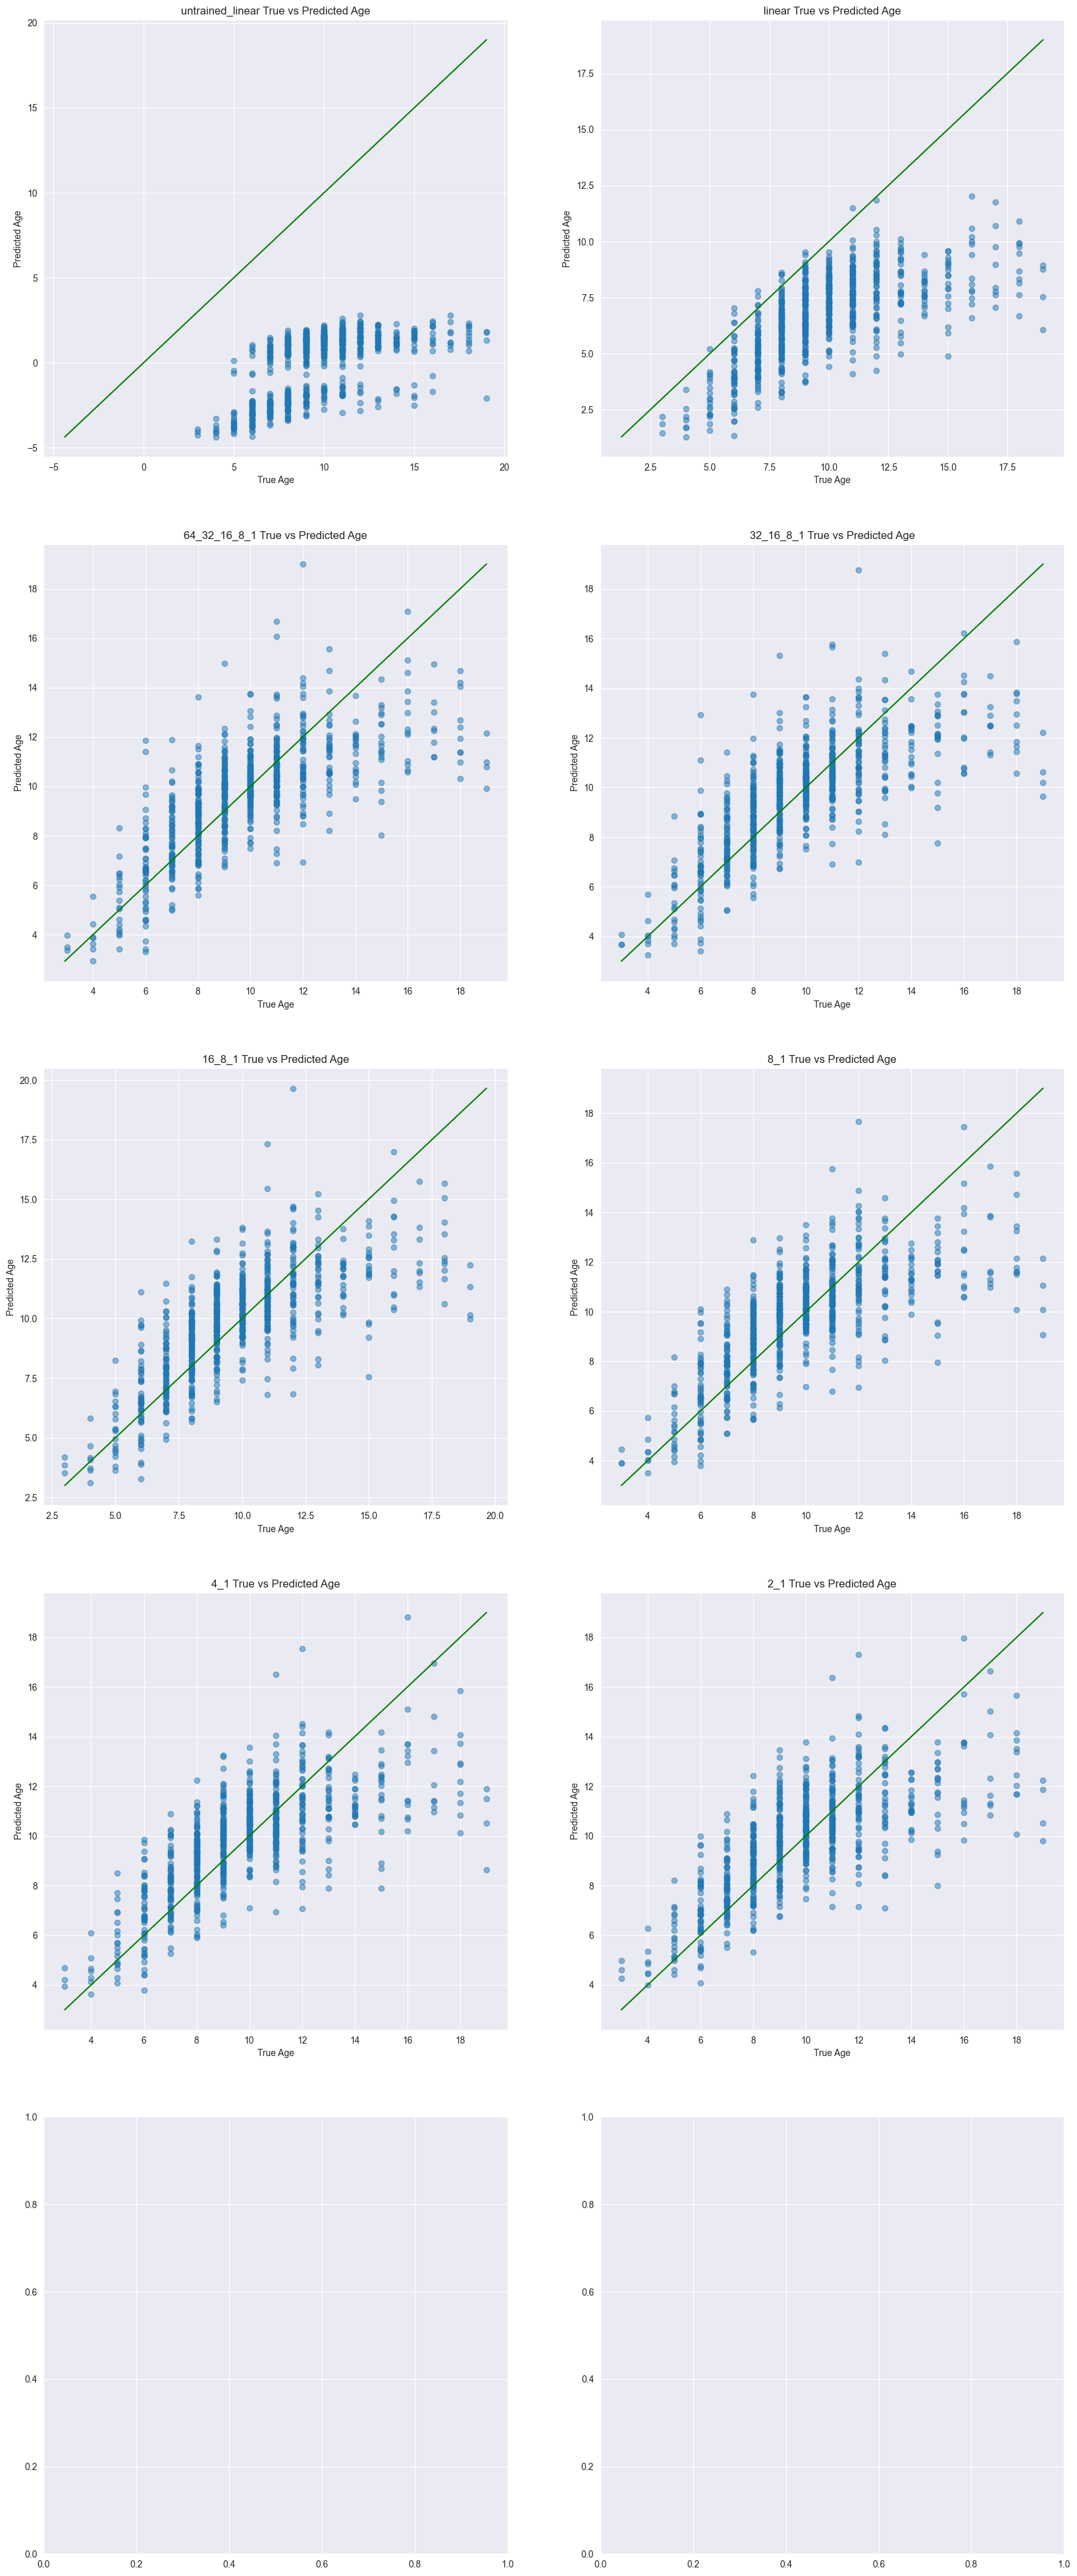

In [163]:
%%time
all_preds = {
    'untrained_linear': {'true': y_test, 'pred': untrained_linear_preds},
    'linear': {'true': y_test, 'pred': linear_preds},
    '64_32_16_8_1': {'true': y_test, 'pred': deepest_preds},
    '32_16_8_1': {'true': y_test, 'pred': deep_32_16_8_preds},
    '16_8_1': {'true': y_test, 'pred': deep_16_8_preds},
    '8_1': {'true': y_test, 'pred': deep_8_preds},
    '4_1': {'true': y_test, 'pred': deep_4_preds},
    '2_1': {'true': y_test, 'pred': deep_2_preds}
}

plot_true_vs_pred_from_dict(all_preds, show_target_line=True)


#### True vs Predicted Age Scatter Plot Observations

The one with only 2 neurons did better than the one with 4 neurons, but still degraded from the 8+-neuron models.

Let's train for more iterations and draw their training loss.

### Training Loss Over Time Plots

Now we'll show the training loss over time. This gives us insight into how quickly the model is learning. It can also show us if the model is overfitting or not.

Training loss should decrease over time, but if the validation loss starts to increase, the model is overfitting.

CPU times: total: 46.9 ms
Wall time: 52.8 ms


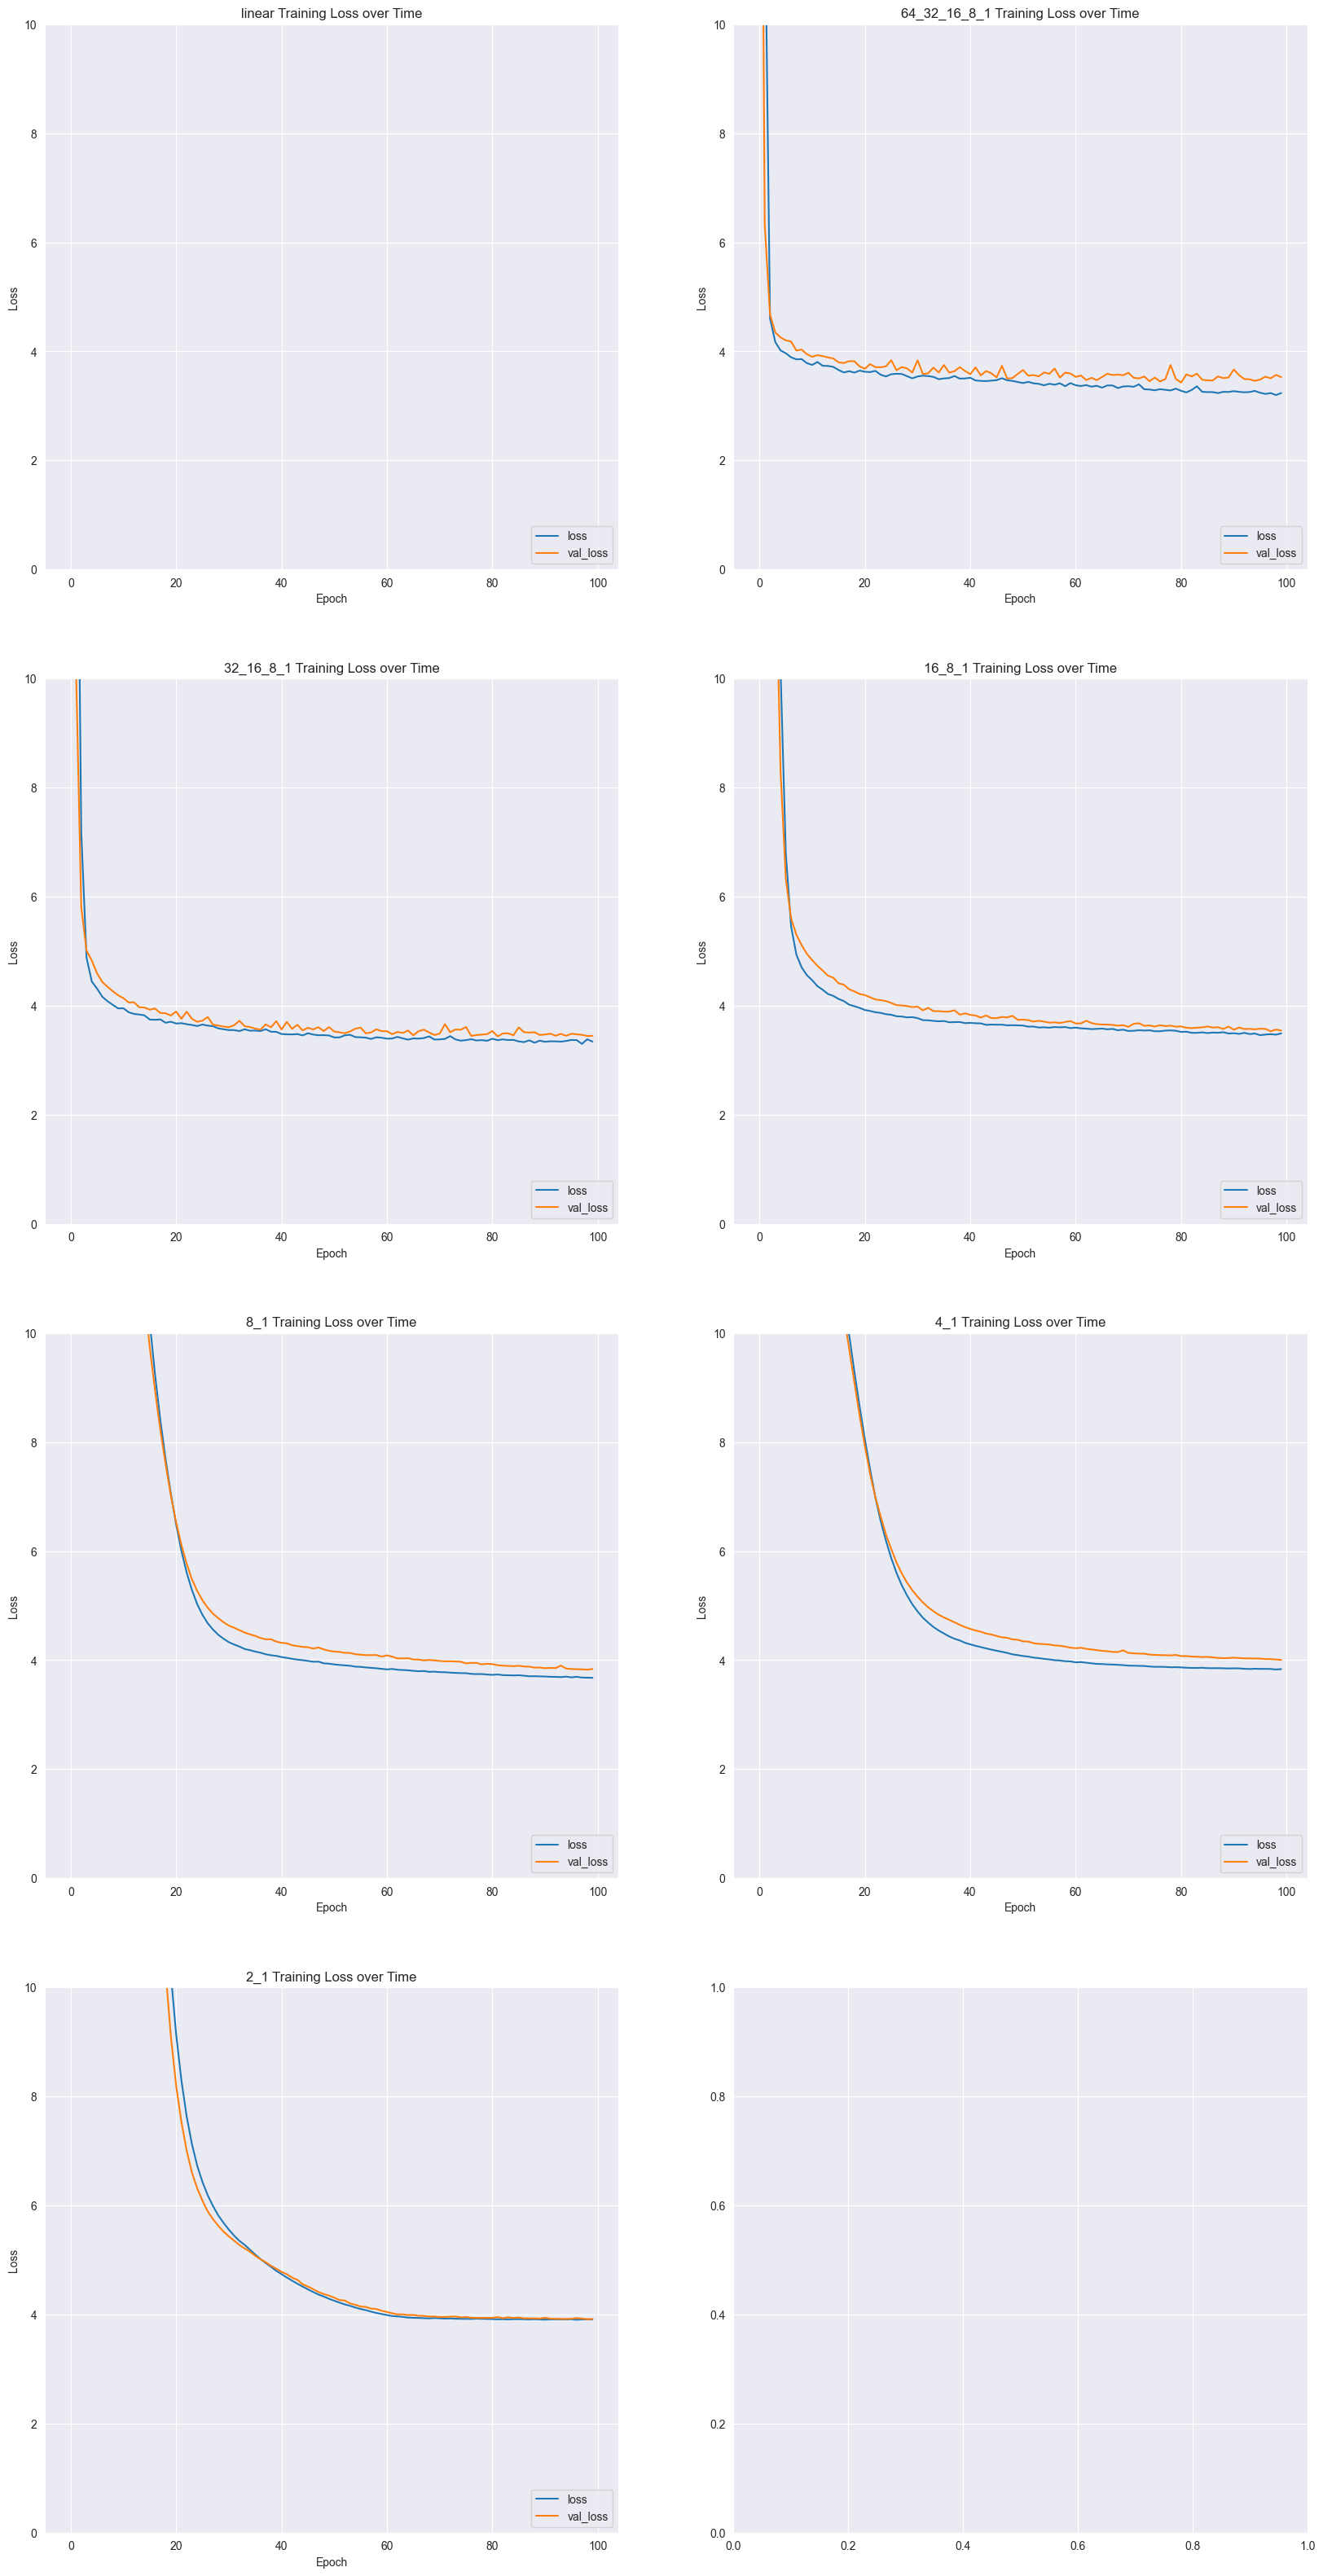

In [164]:
%%time
all_histories = {
    'linear': linear_history,
    '64_32_16_8_1': deepest_history,
    '32_16_8_1': deep_32_16_8_history,
    '16_8_1': deep_16_8_history,
    '8_1': deep_8_history,
    '4_1': deep_4_history,
    '2_1': deep_2_history
}

plot_training_loss_from_dict(all_histories)


#### Training Loss Over Time Observations

Pretty cool, huh?


### Re-Train the Models Again

Let's start over, but this time for longer.

Give them 5x as many epochs this time.


##### Linear Model

CPU times: total: 6.84 s
Wall time: 33.8 s


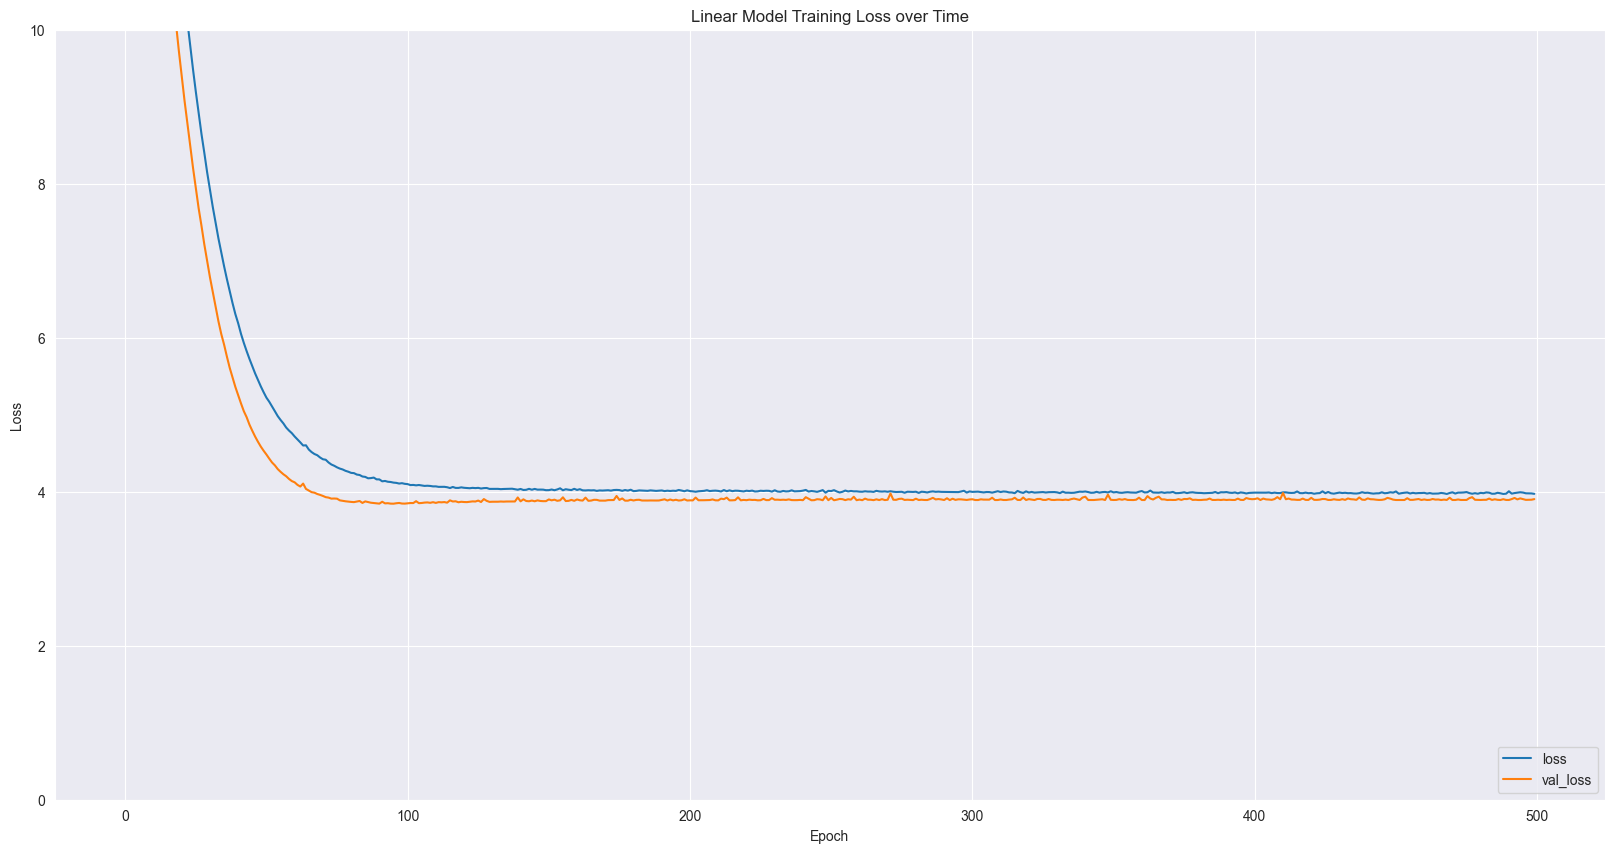

In [165]:
%%time
# add more epochs
#     common_fit_options = {
#         'x': X_train,
#         'y': y_train,
#         'epochs': NUM_EPOCHS*5,
#         'verbose': 0,
#         'validation_split': VALIDATION_SPLIT
#     }
common_fit_options['epochs'] = NUM_EPOCHS*5

all_models['linear'] = keras.models.clone_model(all_models['linear'])
all_models['linear'].compile(**common_compile_options())

all_histories.update({'linear': all_models['linear'].fit(
    **common_fit_options,
    callbacks=[linear_checkpoint]
)})

plot_training_loss(all_histories['linear'], 'Linear Model')


##### Neural Network Model (64-32-16-8-1)

CPU times: total: 10.9 s
Wall time: 38.5 s


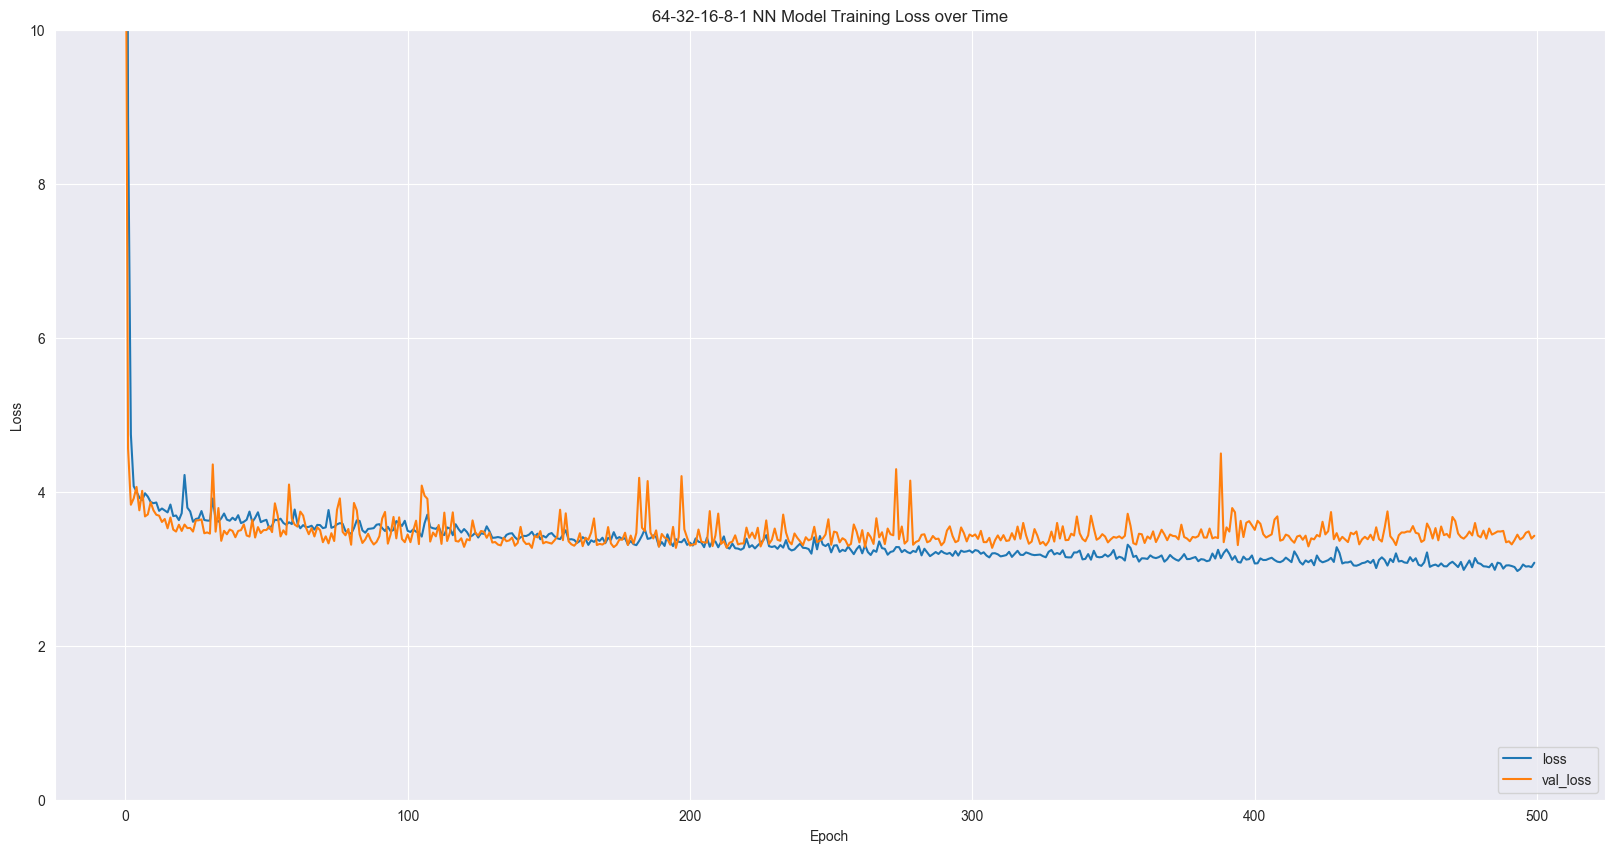

In [166]:
%%time
all_models['64_32_16_8_1'] = keras.models.clone_model(all_models['64_32_16_8_1'])
all_models['64_32_16_8_1'].compile(**common_compile_options())

all_histories.update({'64_32_16_8_1':
    all_models['64_32_16_8_1'].fit(
        **common_fit_options,
        callbacks=[deepest_checkpoint])})

plot_training_loss(all_histories['64_32_16_8_1'], '64-32-16-8-1 NN Model')


(64-32-16-8-1) is definitely overfitting. Let's try the next one.

##### Neural Network Model (32-16-8-1)

CPU times: total: 9.17 s
Wall time: 37 s


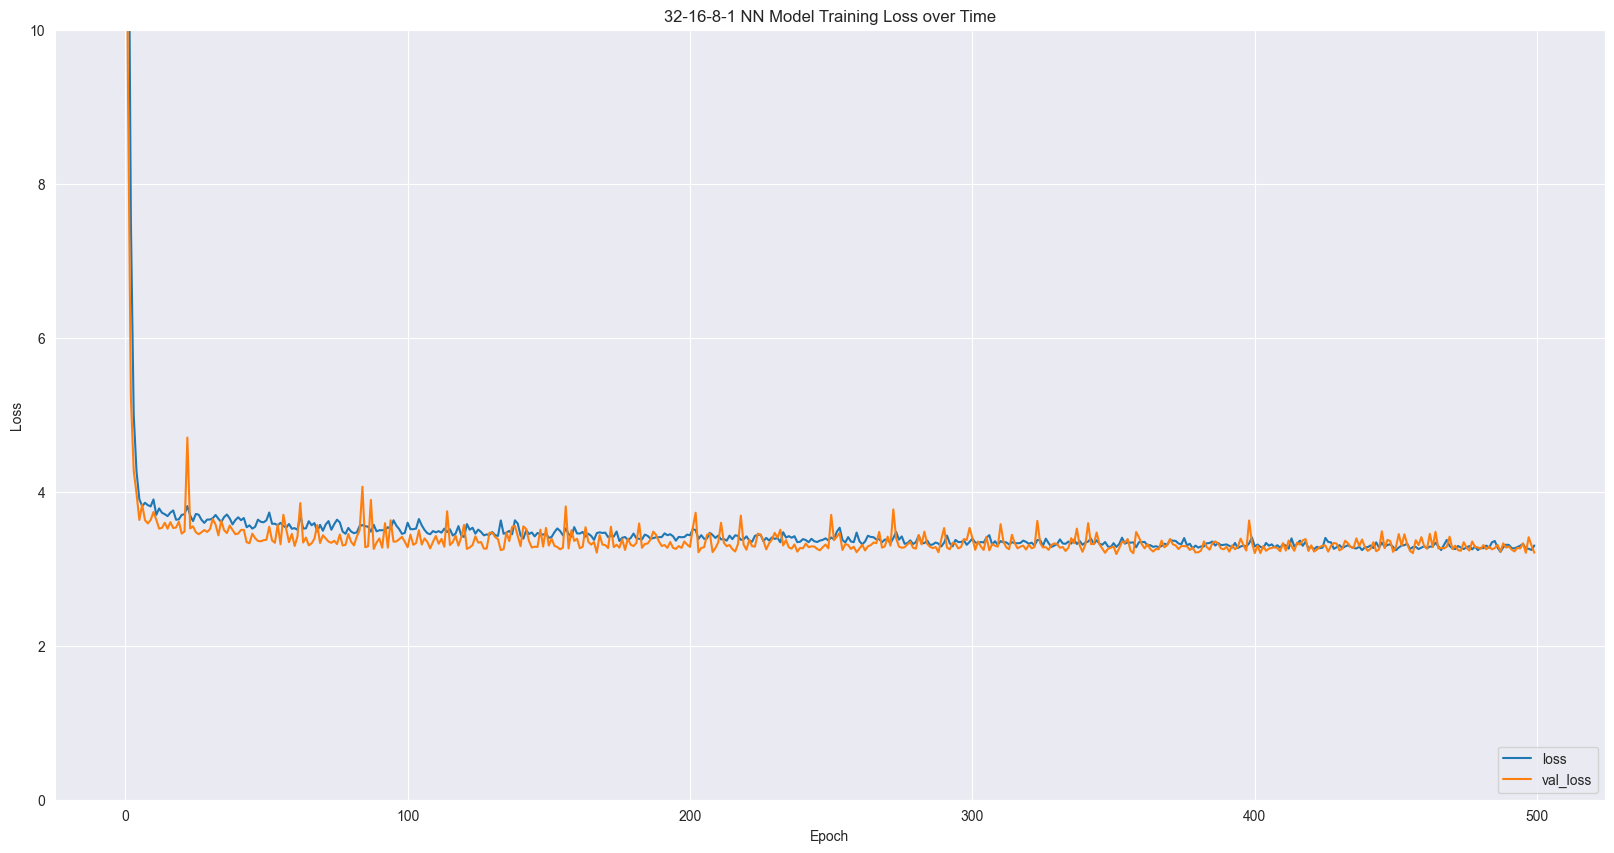

In [167]:
%%time
all_models['32_16_8_1'] = keras.models.clone_model(all_models['32_16_8_1'])
all_models['32_16_8_1'].compile(**common_compile_options())

all_histories.update({'32_16_8_1':
    all_models['32_16_8_1'].fit(
        **common_fit_options,
        callbacks=[deep_32_16_8_checkpoint])})

plot_training_loss(all_histories['32_16_8_1'], '32-16-8-1 NN Model')


(32-16-8-1) still overfitting, but not as bad. Let's keep going.

##### Neural Network Model (16-8-1)

CPU times: total: 8.64 s
Wall time: 35.7 s


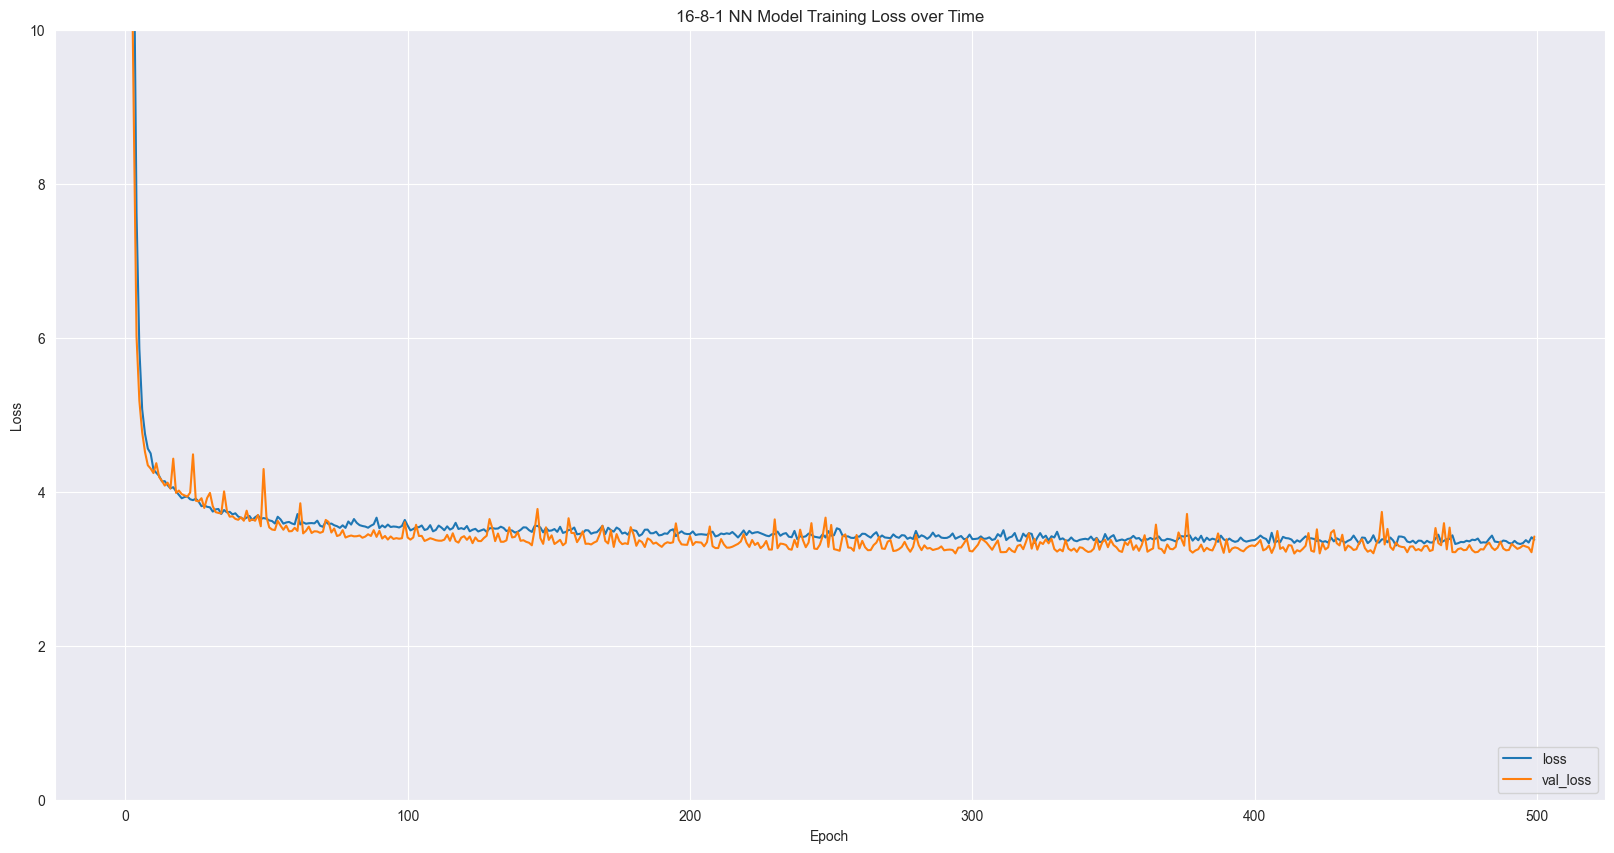

In [168]:
%%time
all_models['16_8_1'] = keras.models.clone_model(all_models['16_8_1'])
all_models['16_8_1'].compile(**common_compile_options())

all_histories.update({'16_8_1':
    all_models['16_8_1'].fit(
        **common_fit_options,
        callbacks=[deep_16_8_checkpoint])})

plot_training_loss(all_histories['16_8_1'], '16-8-1 NN Model')


Validation loss is remaining steady, and the training loss is decreasing ever so slightly. It *might* be overfitting, but it's hard to tell.

##### Neural Network Model (8-1)

CPU times: total: 9.94 s
Wall time: 34.9 s


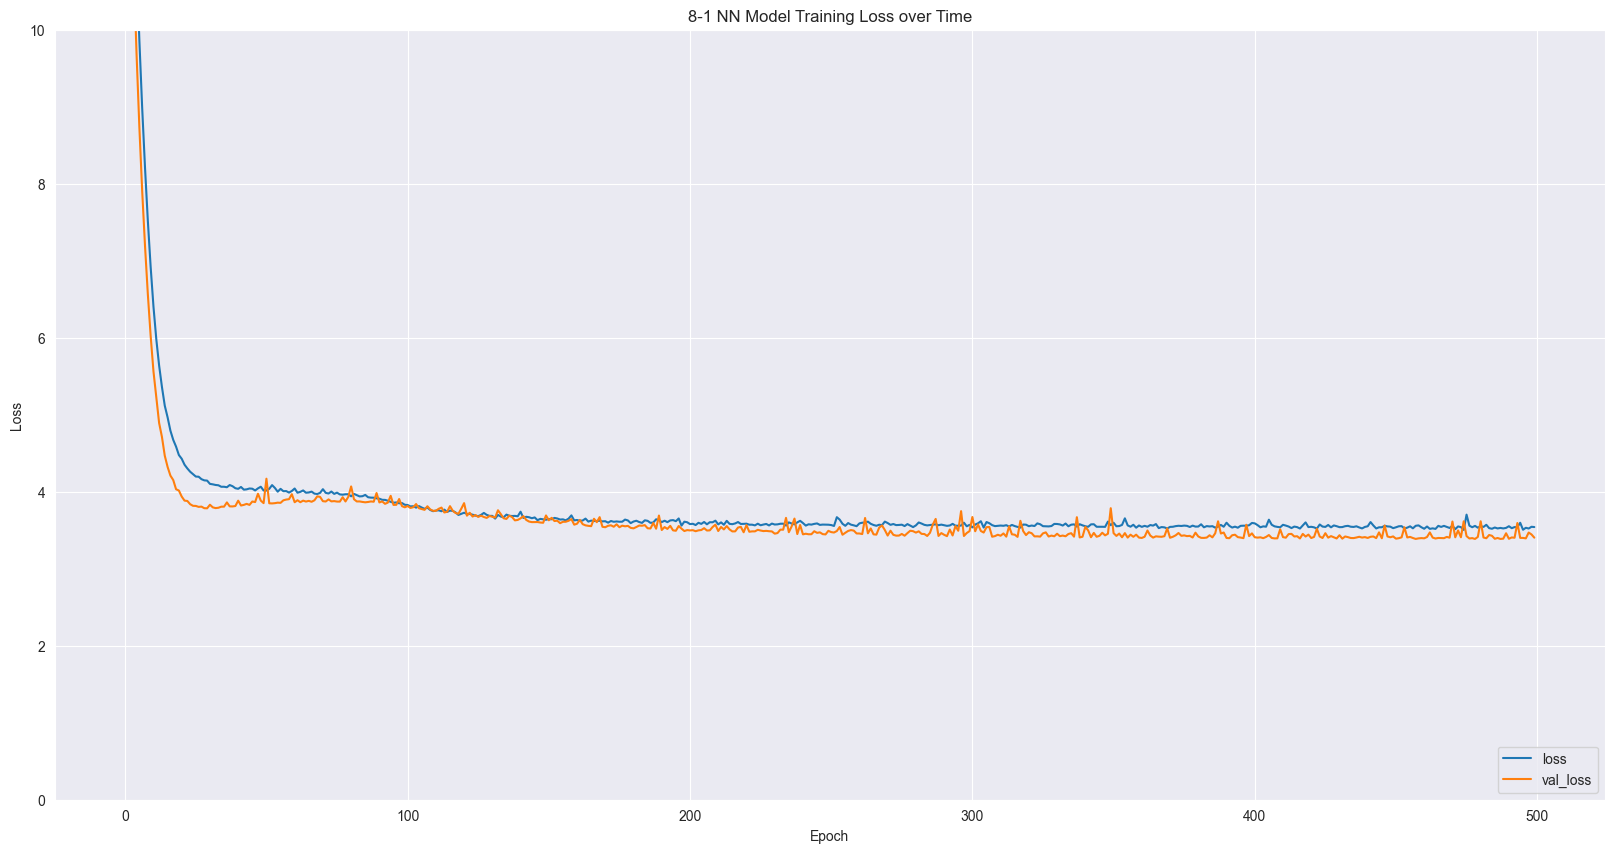

In [169]:
%%time
all_models['8_1'] = keras.models.clone_model(all_models['8_1'])
all_models['8_1'].compile(**common_compile_options())

all_histories.update({'8_1':
    all_models['8_1'].fit(
        **common_fit_options,
        callbacks=[deep_8_checkpoint])})

plot_training_loss(all_histories['8_1'], '8-1 NN Model')


(8-1) doesn't seem to be overfitting. Let's keep it in mind.

##### Neural Network Model (4-1)

CPU times: total: 11.7 s
Wall time: 34.6 s


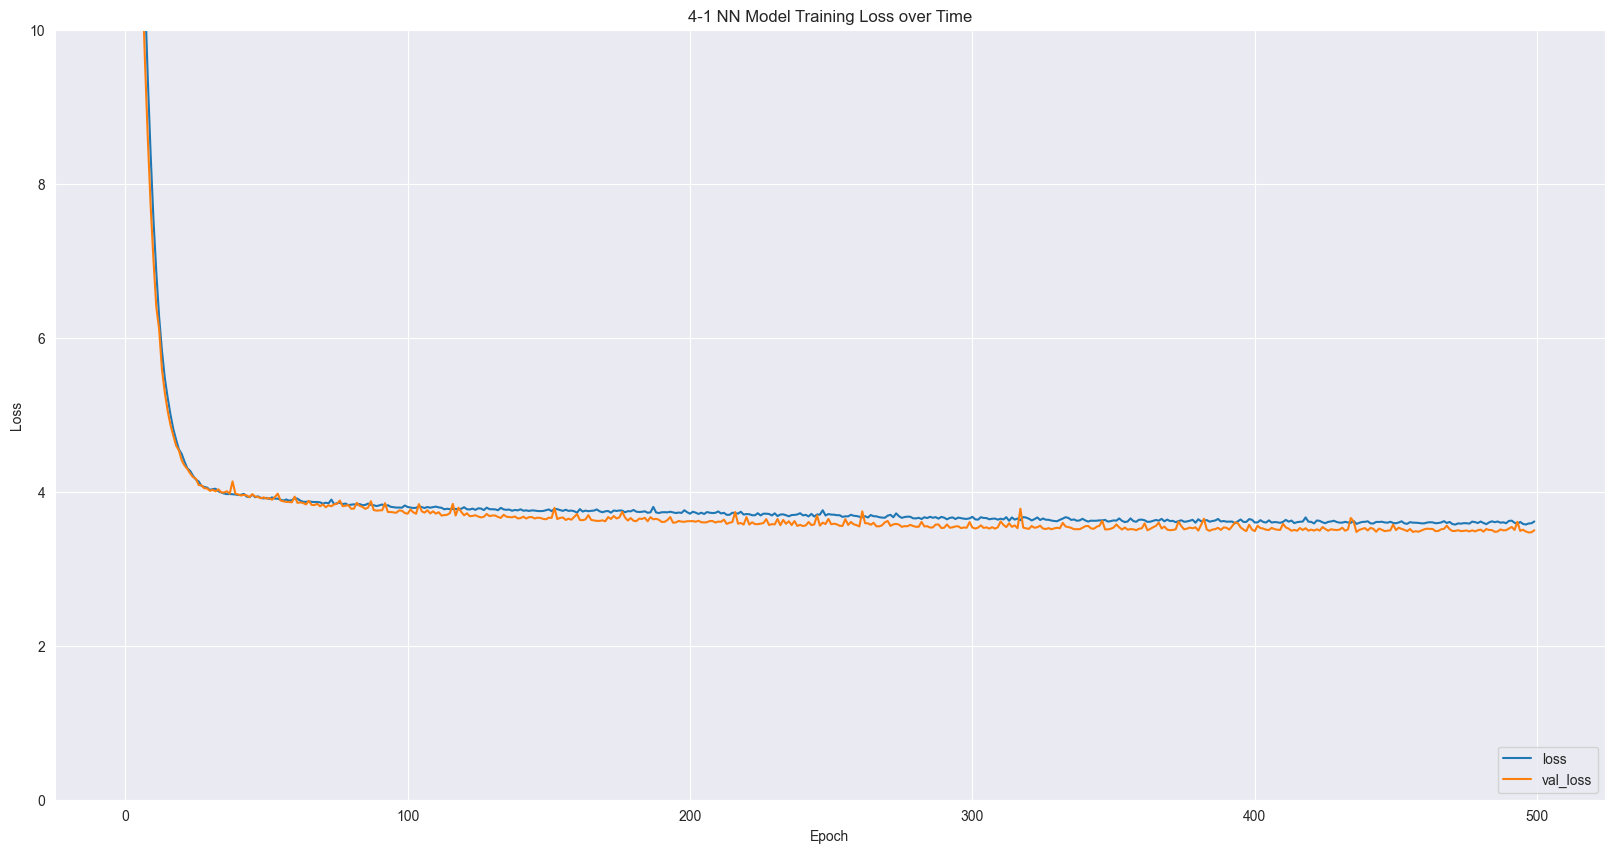

In [170]:
%%time
all_models['4_1'] = keras.models.clone_model(all_models['4_1'])
all_models['4_1'].compile(**common_compile_options())

all_histories.update({'4_1':
    all_models['4_1'].fit(
        **common_fit_options,
        callbacks=[deep_4_checkpoint])})

plot_training_loss(all_histories['4_1'], '4-1 NN Model')


(4-1) Looks pretty good!

##### Neural Network Model (2-1)

CPU times: total: 7.61 s
Wall time: 34.6 s


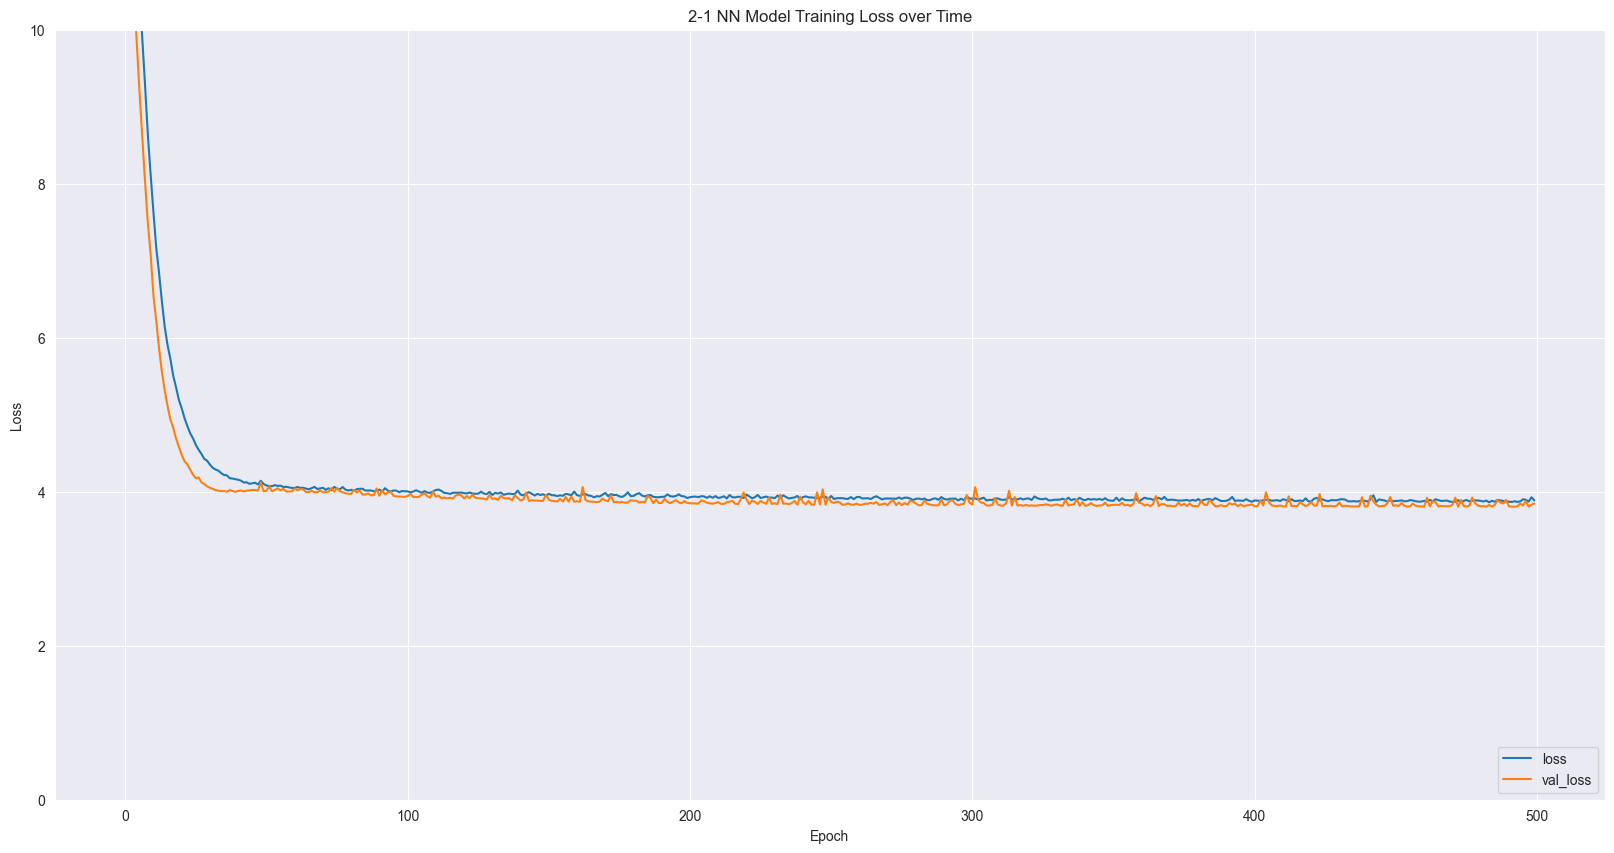

In [171]:
%%time
all_models['2_1'] = keras.models.clone_model(all_models['2_1'])
all_models['2_1'].compile(**common_compile_options())

all_histories.update({'2_1':
    all_models['2_1'].fit(
        **common_fit_options,
        callbacks=[deep_2_checkpoint])})

plot_training_loss(all_histories['2_1'], '2-1 NN Model')


### Re-Plot Training Loss Over Time

Over 500 epochs, we can see how the models are learning.


CPU times: total: 46.9 ms
Wall time: 52.1 ms


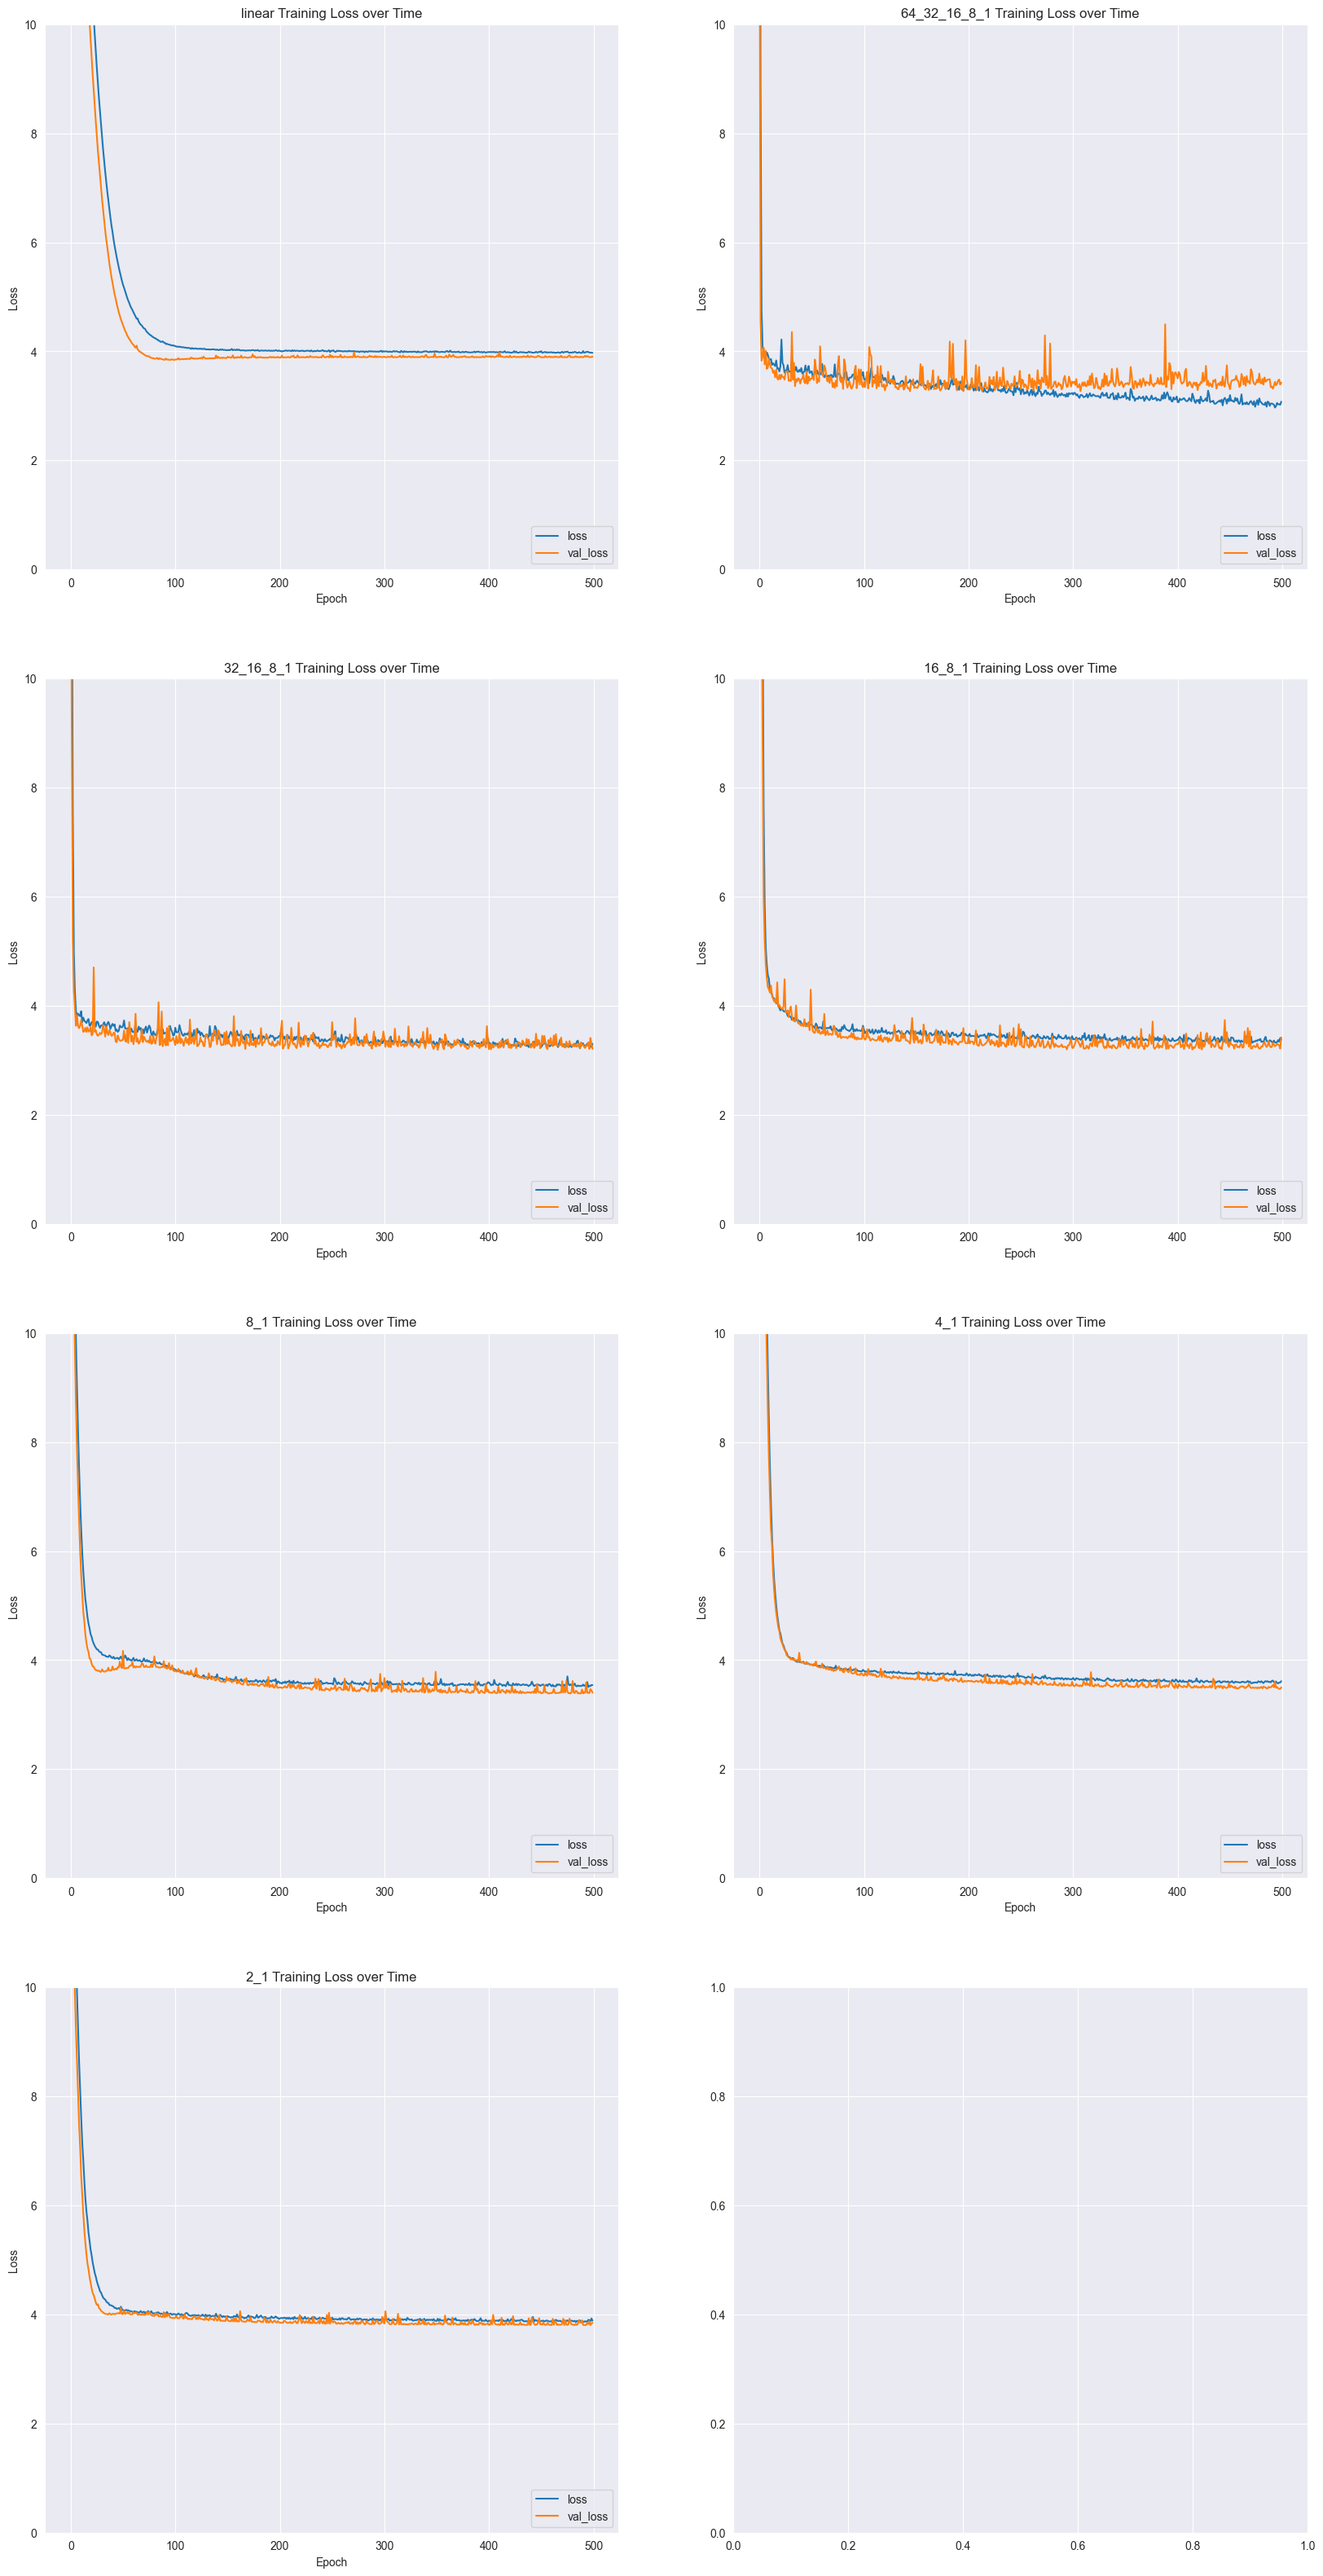

In [172]:
%%time
plot_training_loss_from_dict(all_histories)


## Model Leaderboard

Let's re-score the models and see how they compare.

### My Criteria

- Mean Absolute Error within 2 years.
- Reasonable Explained Variance Score
- Reasonable R2 Score
- Avoid Overfitting
- Reasonable Learning Rate


In [173]:
%%time
# score each model
all_models = {
    'linear': all_models['linear'],
    '64_32_16_8_1': all_models['64_32_16_8_1'],
    '32_16_8_1': all_models['32_16_8_1'],
    '16_8_1': all_models['16_8_1'],
    '8_1': all_models['8_1'],
    '4_1': all_models['4_1'],
    '2_1': all_models['2_1']
}

# score on the test set
for model_name, model in all_models.items():
    preds = model.predict(X_test).flatten()
    scores_df = score_model(preds, np.array(y_test), index=model_name)
    leaderboard_df = score_combine(leaderboard_df, scores_df)

# copy untrained linear model scores - random doesn't get another chance here for time's sake
training_leaderboard_df = leaderboard_df.loc[['untrained_linear']]
# score on the training set
for model_name, model in all_models.items():
    preds = model.predict(X_train).flatten()
    scores_df = score_model(preds, np.array(y_train), index=model_name+'_train')
    training_leaderboard_df = score_combine(training_leaderboard_df, scores_df)

leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
CPU times: total: 531 ms
Wall time: 1.28 s


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124
linear,3.989072,1.460823,-0.018658,-0.023083
64_32_16_8_1,3.947005,1.446905,0.254409,0.253218
32_16_8_1,3.624803,1.405332,0.281810,0.280649
16_8_1,3.775543,1.483580,0.344511,0.319268
8_1,3.721601,1.403608,0.229126,0.226893
4_1,3.771932,1.433586,0.175989,0.175290
2_1,3.899559,1.447496,0.059275,0.049026


In [191]:
%%time
training_leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124
linear_train,3.965077,1.465525,0.018993,0.016982
64_32_16_8_1_train,3.018326,1.276993,0.416124,0.415677
32_16_8_1_train,3.184567,1.308043,0.375946,0.375154
16_8_1_train,3.462085,1.415483,0.421002,0.394874
8_1_train,3.491538,1.351569,0.284945,0.283998
4_1_train,3.552142,1.385586,0.241159,0.239987
2_1_train,3.877626,1.442509,0.079220,0.073018


### Reminder of Our Metrics

#### Mean Squared Error
 
- The best score is 0.0
- Lower is better.

#### Mean Absolute Error

- The best score is 0.0
- Lower is better.
- Less sensitive to outliers.

#### Explained Variance Score

- The best score is 1.0
- Lower is worse.

#### R2 Score

- The best score is 1.0
- Lower is worse.


### Model Type Comparison

***Note**: Exclude the untrained linear model and MSE metric from these graphs for clarity.*


CPU times: total: 0 ns
Wall time: 22.5 ms


<Axes: title={'center': 'Feature-Rich vs Deep Learning Model Scores'}>

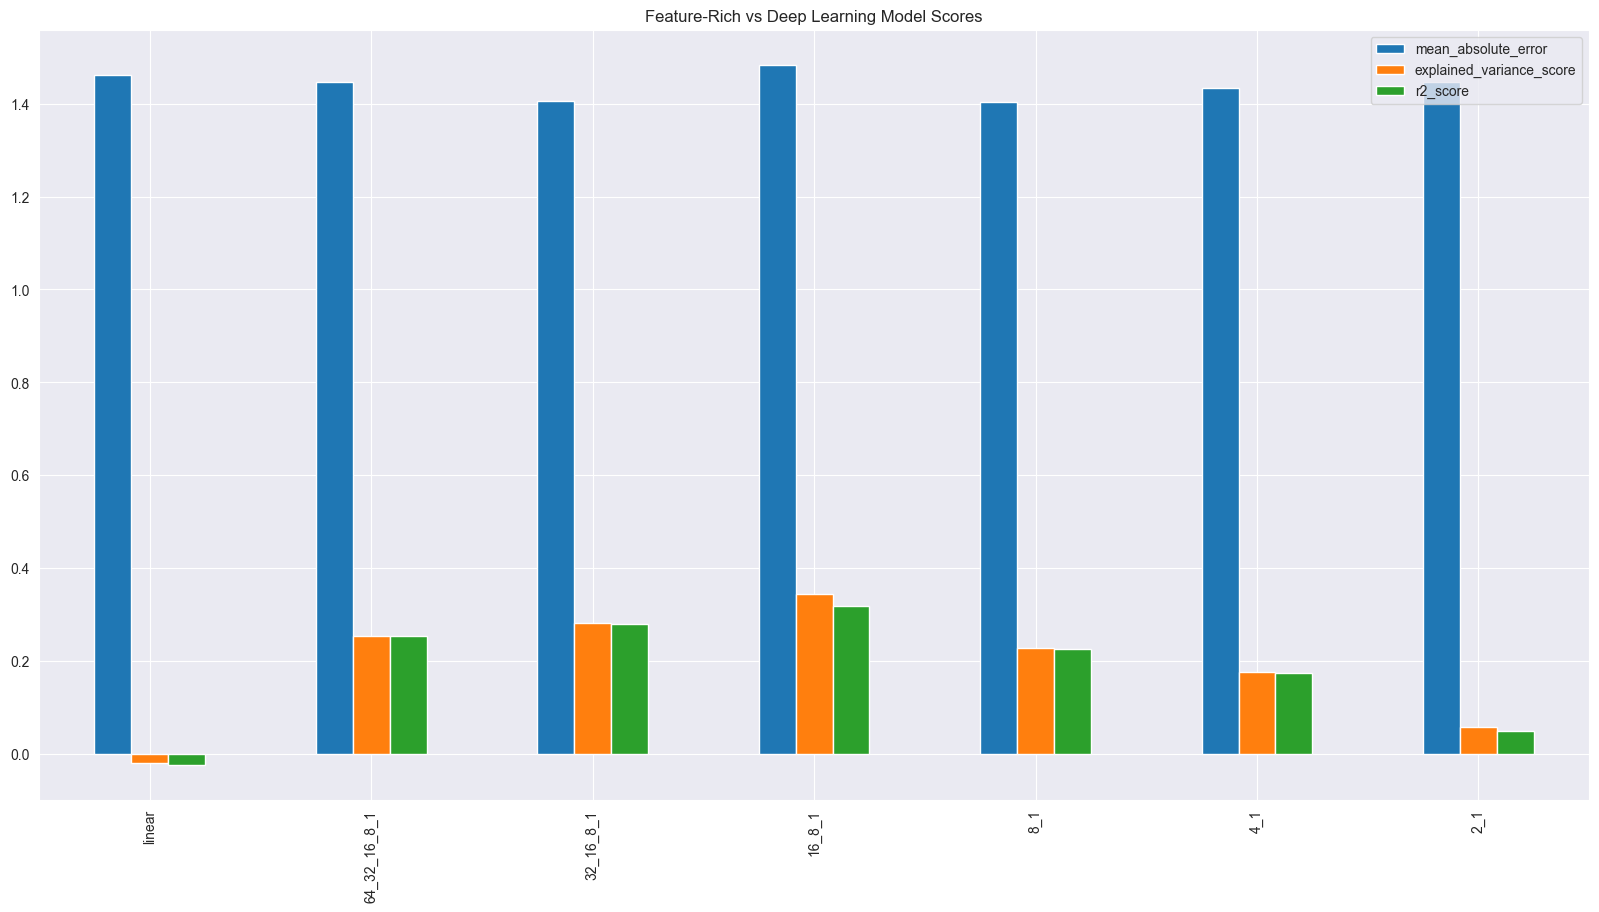

In [207]:
%%time
# exclude the untrained linear model, MSE from this graph for clarity
clarified_leaderboard_df = leaderboard_df.drop('untrained_linear').drop(['mean_squared_error'], axis=1)
clarified_leaderboard_df.plot(kind='bar', title='Feature-Rich vs Deep Learning Model Scores', figsize=(20, 10))


Wow, it's hard to see the differences between the models. Let's look at the scores side-by-side.

### Overfitting or Underfitting?

Plot the training and testing scores side-by-side to see if the models are overfitting or underfitting.

#### Linear Model

CPU times: total: 141 ms
Wall time: 208 ms


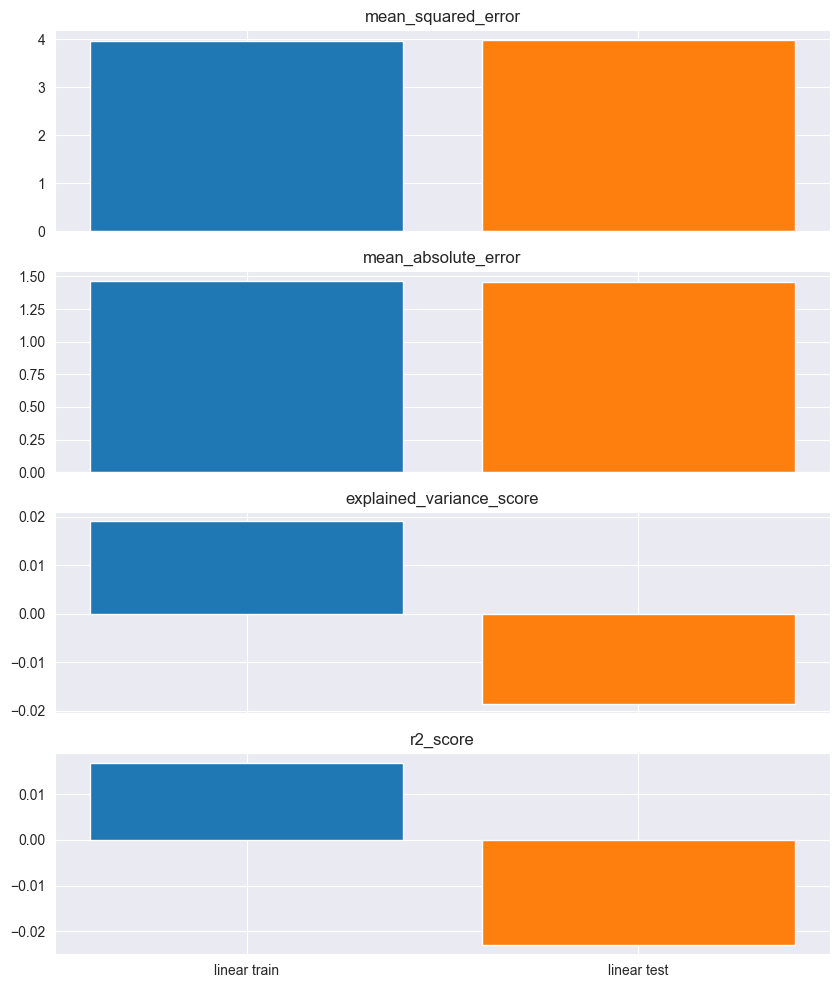

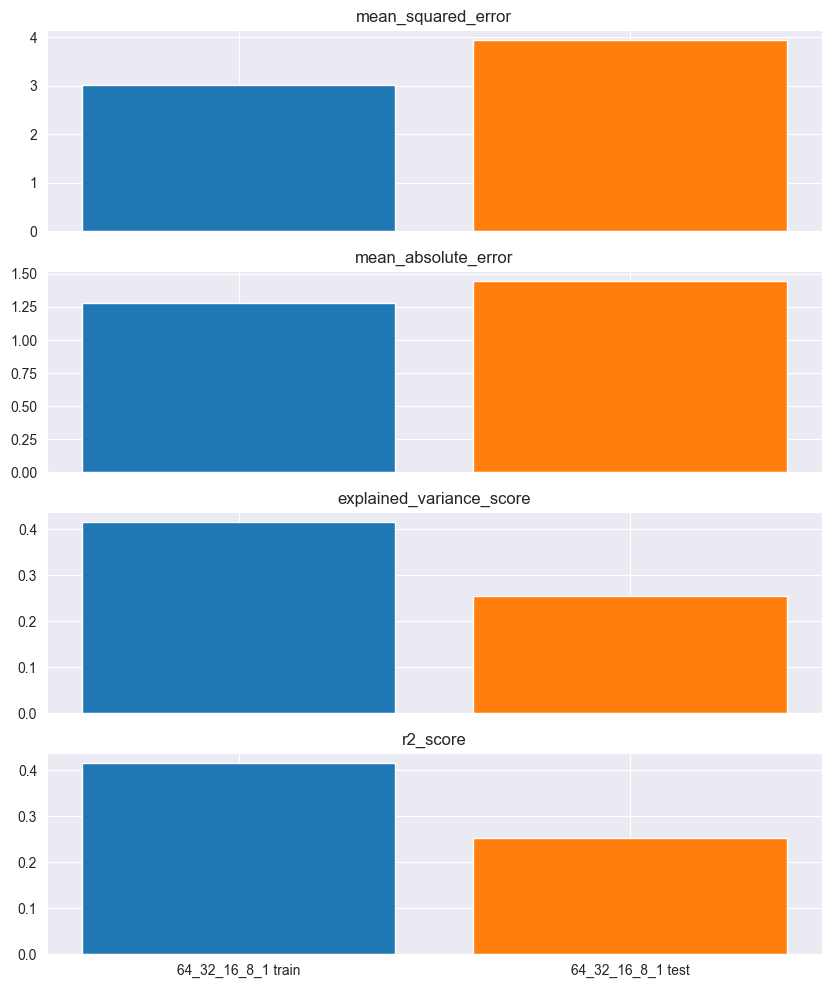

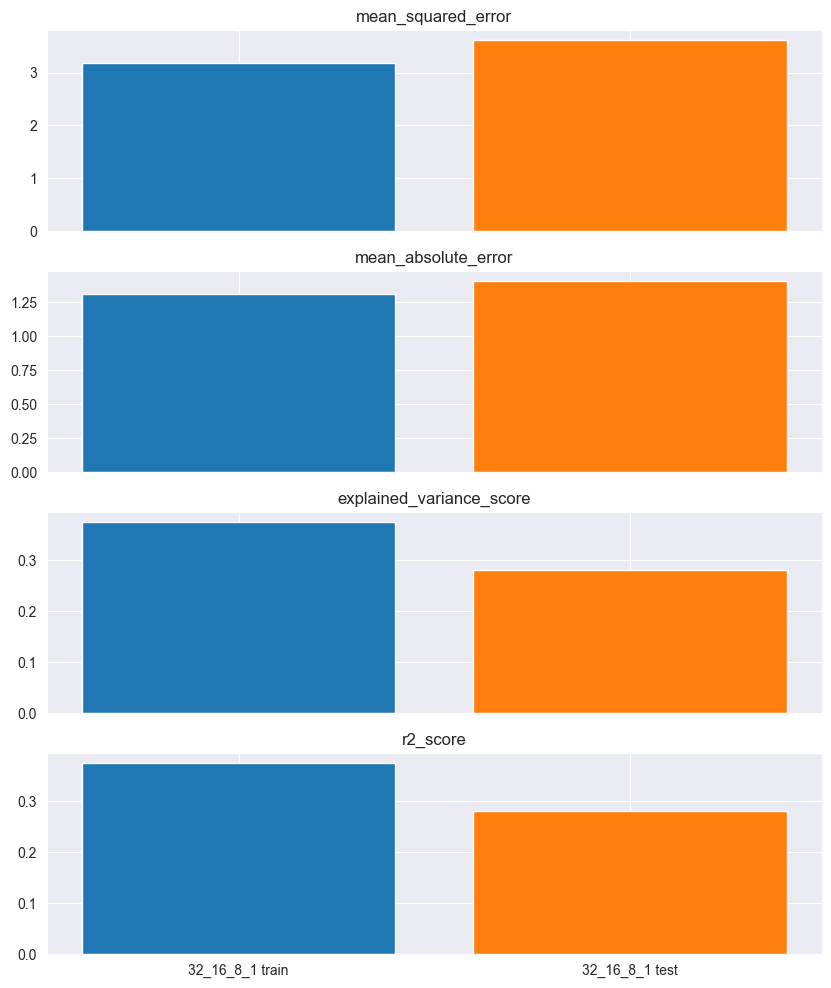

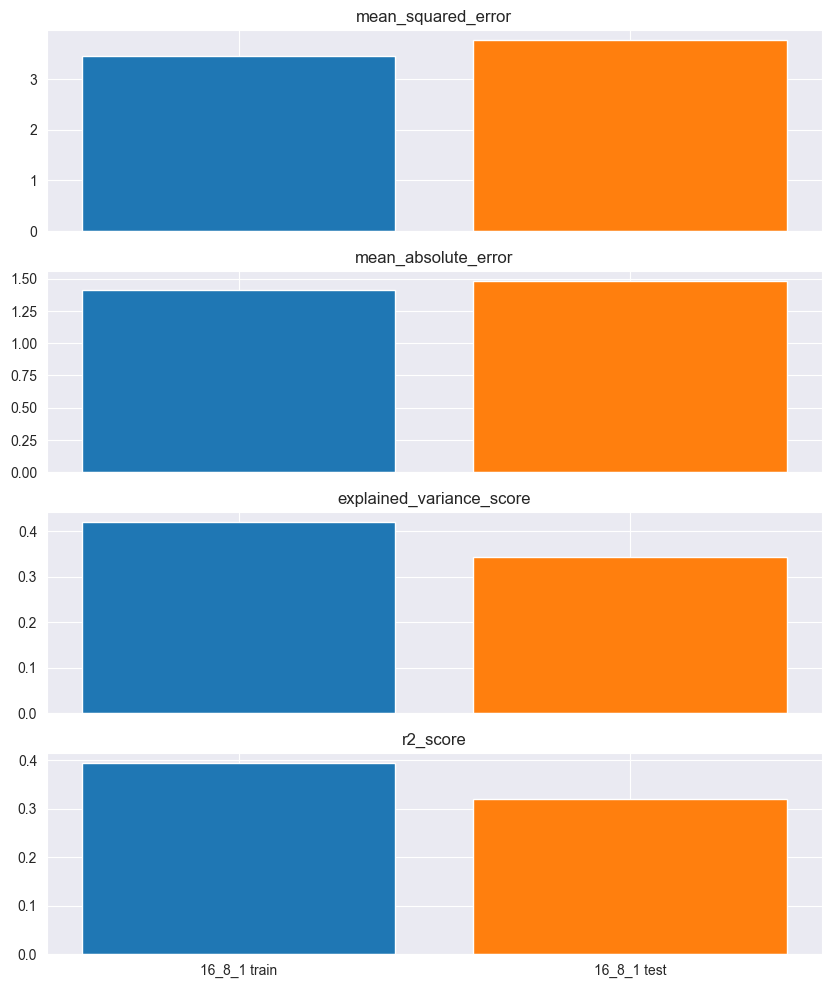

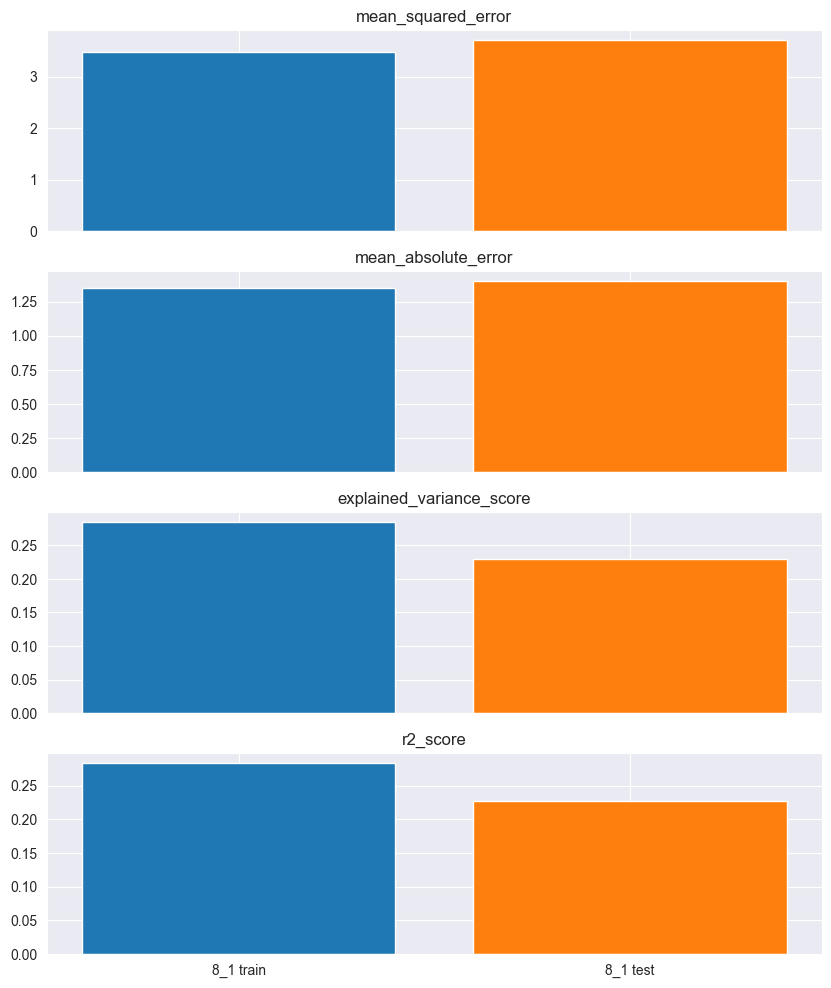

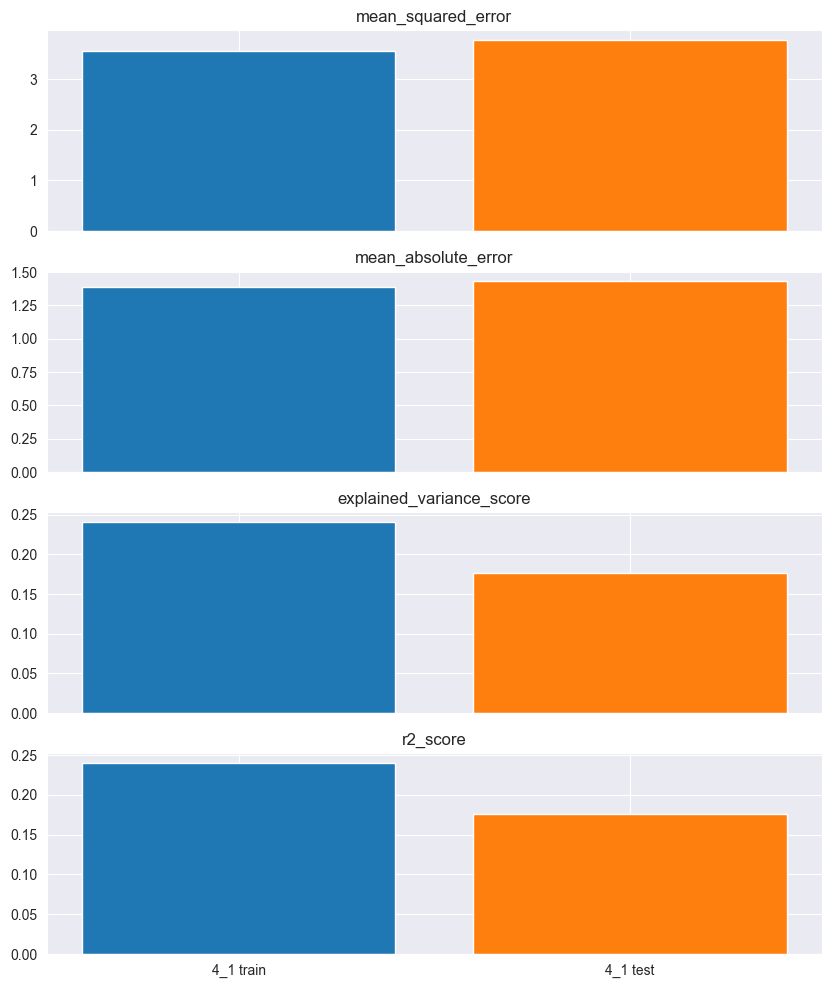

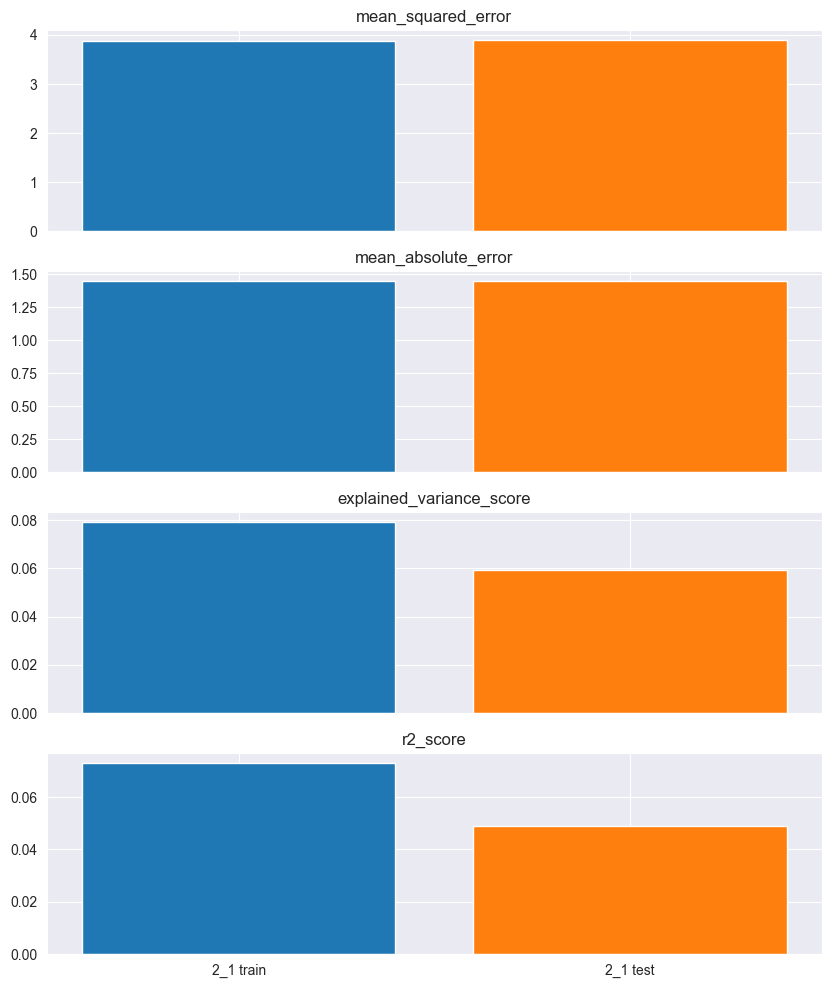

In [208]:
%%time
all_score_comparisons = {
    'linear': score_comparator(
        training_leaderboard_df.loc[['linear_train']],
        leaderboard_df.loc[['linear']],
        'linear train',
        'linear test'),
    '64_32_16_8_1': score_comparator(
        training_leaderboard_df.loc[['64_32_16_8_1_train']],
        leaderboard_df.loc[['64_32_16_8_1']],
        '64_32_16_8_1 train',
        '64_32_16_8_1 test'),
    '32_16_8_1': score_comparator(
        training_leaderboard_df.loc[['32_16_8_1_train']],
        leaderboard_df.loc[['32_16_8_1']],
        '32_16_8_1 train',
        '32_16_8_1 test'),
    '16_8_1': score_comparator(
        training_leaderboard_df.loc[['16_8_1_train']],
        leaderboard_df.loc[['16_8_1']],
        '16_8_1 train',
        '16_8_1 test'),
    '8_1': score_comparator(
        training_leaderboard_df.loc[['8_1_train']],
        leaderboard_df.loc[['8_1']],
        '8_1 train',
        '8_1 test'),
    '4_1': score_comparator(
        training_leaderboard_df.loc[['4_1_train']],
        leaderboard_df.loc[['4_1']],
        '4_1 train',
        '4_1 test'),
    '2_1': score_comparator(
        training_leaderboard_df.loc[['2_1_train']],
        leaderboard_df.loc[['2_1']],
        '2_1 train',
        '2_1 test')}


Linear model might be overfitting.

#### Neural Network Model (64-32-16-8-1)

In [209]:
%%time


CPU times: total: 0 ns
Wall time: 0 ns


(64-32-16-8-1) is definitely overfitting.

#### Neural Network Model (32-16-8-1)

In [210]:
%%time


CPU times: total: 0 ns
Wall time: 0 ns


(32-16-8-1) is overfitting.

#### Neural Network Model (16-8-1)

In [211]:
%%time


CPU times: total: 0 ns
Wall time: 0 ns


(16-8-1) is overfitting.

#### Neural Network Model (8-1)

In [212]:
%%time


CPU times: total: 0 ns
Wall time: 0 ns


(8-1) is not overfitting too much.

#### Neural Network Model (4-1)

In [213]:
%%time


CPU times: total: 0 ns
Wall time: 0 ns


(4-1) is not overfitting too much either.

#### Neural Network Model (2-1)

In [214]:
%%time


CPU times: total: 0 ns
Wall time: 0 ns


(2-1) is not overfitting too much either.


### Show the Leaderboard Again

In [215]:
%%time
leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 0 ns


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124
linear,3.989072,1.460823,-0.018658,-0.023083
64_32_16_8_1,3.947005,1.446905,0.254409,0.253218
32_16_8_1,3.624803,1.405332,0.281810,0.280649
16_8_1,3.775543,1.483580,0.344511,0.319268
8_1,3.721601,1.403608,0.229126,0.226893
4_1,3.771932,1.433586,0.175989,0.175290
2_1,3.899559,1.447496,0.059275,0.049026


#### On Training Data

Hopefully they did not do much better than their test counterparts.

In [216]:
%%time
training_leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 0 ns


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,100.837997,9.767451,-0.557366,-27.895124
linear_train,3.965077,1.465525,0.018993,0.016982
64_32_16_8_1_train,3.018326,1.276993,0.416124,0.415677
32_16_8_1_train,3.184567,1.308043,0.375946,0.375154
16_8_1_train,3.462085,1.415483,0.421002,0.394874
8_1_train,3.491538,1.351569,0.284945,0.283998
4_1_train,3.552142,1.385586,0.241159,0.239987
2_1_train,3.877626,1.442509,0.079220,0.073018


#### Score These Scores

Why not?

These scores will show the level of similarity between the prediction on the test set vs. the training set.

This could be a good way to see if the model is overfitting or underfitting.


In [217]:
%%time
score_score_leaderboard_df = pd.DataFrame()

for model_name in leaderboard_df.index:
    if model_name == 'untrained_linear':
        continue
    score_score_leaderboard_df = score_combine(
        score_score_leaderboard_df,
        score_model(
            leaderboard_df.loc[[model_name]].transpose(),
            training_leaderboard_df.loc[[f'{model_name}_train']].transpose(), index=model_name
        )
    )

score_score_leaderboard_df[:]


CPU times: total: 15.6 ms
Wall time: 39.7 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
linear,0.000905,0.026603,0.999742,0.999663
64_32_16_8_1,0.235965,0.355691,0.912699,0.896213
32_16_8_1,0.055266,0.181541,0.974422,0.970339
16_8_1,0.028615,0.133413,0.987188,0.985523
8_1,0.015503,0.098757,0.993258,0.992379
4_1,0.014761,0.099414,0.993706,0.993154
2_1,0.000370,0.017715,0.999857,0.999850


## Choose the Best Model for the Job

Those pesky crabs don't want us to know how old they are. We'll find out soon enough.

First, let's choose the best model for the job.

### My Criteria

- Mean Absolute Error within 2 years.
- Reasonable Explained Variance Score
- Reasonable R2 Score
- Avoid Overfitting
- Reasonable Learning Rate

Based on low MSE, high R2, and high Explained Variance, the best model is the (8-1) neural network model.

### Pursue the (8-1) Neural Network Model

Let's try some hyperparameter tuning on the (8-1) neural network model.


## Hyperparameter Tuning

Next, we will tune the hyperparameters of the (8-1) neural network model.

### Schedule the Learning Rate

Let's use what we learned from [simulated annealing](https://github.com/ahester57/ai_workshop/tree/master/notebooks/simulated_annealing) to schedule the learning rate.


In [218]:
%%time
deep_model = keras.models.clone_model(all_models['8_1'])

learning_rate_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    verbose=1,
    mode='min'
)

deep_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)


deep_model_history = deep_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_8_checkpoint, learning_rate_schedule]
)



Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 88: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 94: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
CPU times: total: 1.19 s
Wall time: 7.46 s


#### Plot the Training Loss for Scheduled vs Static Learning Rate

Let's look for an improvement in the training loss rate over epochs.


CPU times: total: 0 ns
Wall time: 9.52 ms


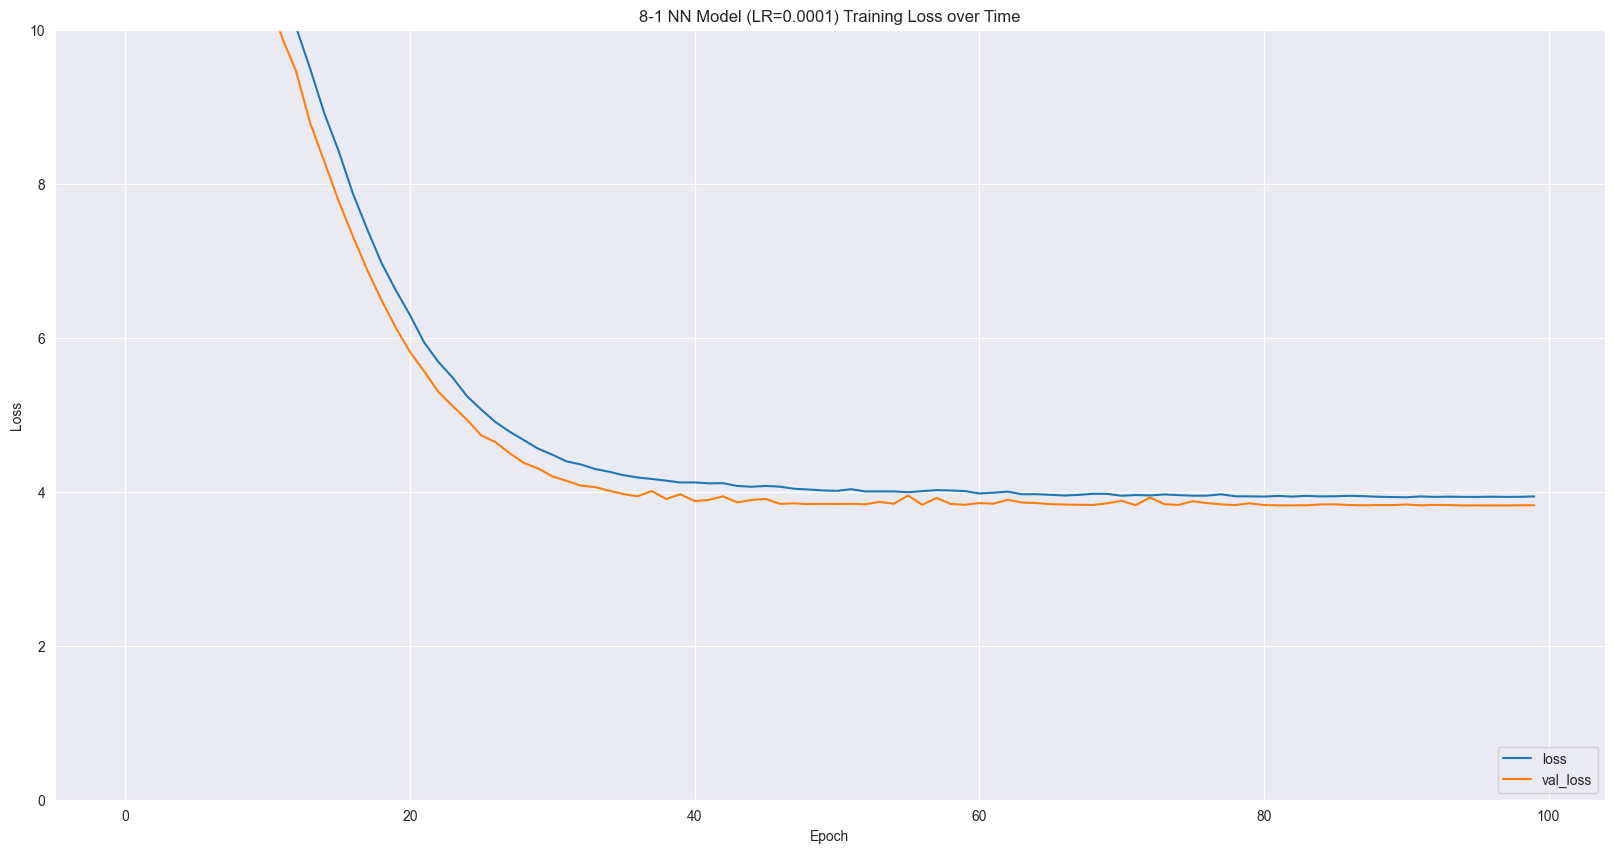

In [219]:
%%time
plot_training_loss(deep_model_history, '8-1 NN Model (LR=0.0001)')


### Loss Function to Mean Absolute Error

Let's try a different loss function to see if it improves the model.

- **Loss Function**
    - Mean Absolute Error (MAE)
        - Less sensitive to outliers.
        - Penalizes all errors equally.

This could be good for our model, as we removed outliers in the data cleaning step.


In [220]:
%%time
deep_model = keras.models.clone_model(all_models['8_1'])




CPU times: total: 0 ns
Wall time: 7.51 ms


## Save the Data

So we can pick this back up on the [next step](../2-features/features.ipynb).


In [221]:
%%time
# save the training and test data separately
pd.concat([X_train, y_train], axis=1, join='outer').to_feather(NEXT_CACHE_FILE)
pd.concat([X_test, y_test], axis=1, join='outer').to_feather(NEXT_CACHE_FILE.replace('.feather', '_test.feather'))


CPU times: total: 0 ns
Wall time: 5 ms


## Onwards to Feature Engineering

See the [next section](../2-features/features.ipynb) for feature engineering.

[`<html link>`](https://nbviewer.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/2-features/features.ipynb) for feature reduction.
